# Neural Network Training Algorithm Comparison

Comparing SGD, SCG, and LeapFrog optimizers across 6 datasets.

## 1. Setup and Imports

In [3]:
! pip install numpy pandas tensorflow-cpu scikit-learn matplotlib seaborn

  Using cached numpy-2.3.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached tensorflow_cpu-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached scikit_learn-1.7.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.6-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using ca

In [39]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
import time
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## 2. Load Datasets

## 3. Neural Network Implementation

In [23]:
! pip install xlrd

In [ ]:
# Add this import
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import load_wine, load_breast_cancer

def load_all_datasets():
    """Load all 6 datasets using ucimlrepo where possible"""
    datasets = {}
    
    print("Loading all datasets using ucimlrepo and fallbacks...")
    
    # CLASSIFICATION DATASETS
    
    # 1. Wine (sklearn - small)
    X, y = load_wine(return_X_y=True)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    datasets['wine'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'classification')
    print("✓ Wine loaded (178 samples, 13 features, 3 classes)")
    
    # 2. Breast Cancer (sklearn - medium)
    X, y = load_breast_cancer(return_X_y=True)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    datasets['breast_cancer'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'classification')
    print("✓ Breast Cancer loaded (569 samples, 30 features, 2 classes)")
    
    # 3. Optical Recognition (large) - try ucimlrepo first
    try:
        optical_data = fetch_ucirepo(id=80)  # Optical Recognition of Handwritten Digits
        X = optical_data.data.features.values
        y = optical_data.data.targets.values.flatten()
        
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
        datasets['optical_recognition'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'classification')
        print(f"✓ Optical Recognition loaded via ucimlrepo ({len(X)} samples, {X.shape[1]} features, 10 classes)")
    except Exception as e:
        # Fallback to manual loading
        try:
            train_data = pd.read_csv('data/optdigits.tra', header=None)
            test_data = pd.read_csv('data/optdigits.tes', header=None)
            all_data = pd.concat([train_data, test_data], ignore_index=True)
            X = all_data.iloc[:, :-1].values
            y = all_data.iloc[:, -1].values
            
            X = StandardScaler().fit_transform(X)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
            datasets['optical_recognition'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'classification')
            print(f"✓ Optical Recognition loaded via fallback ({len(X)} samples, 64 features, 10 classes)")
        except Exception:
            print("✗ Optical Recognition failed to load")
    
    # REGRESSION DATASETS
    
    # 4. Auto MPG (small) - try ucimlrepo first
    try:
        auto_data = fetch_ucirepo(id=9)  # Auto MPG
        X = auto_data.data.features.values
        y = auto_data.data.targets.values.flatten()
        
        # Remove rows with missing values
        mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
        X, y = X[mask], y[mask]
        
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        datasets['auto_mpg'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'regression')
        print(f"✓ Auto MPG loaded via ucimlrepo ({len(X)} samples, {X.shape[1]} features)")
    except Exception as e:
        # Fallback to manual loading
        try:
            auto_data = pd.read_csv('data/auto-mpg.data', sep=r'\s+', header=None, na_values='?')
            auto_data.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
            auto_data = auto_data.drop('name', axis=1).dropna()
            
            X = auto_data.iloc[:, 1:].values
            y = auto_data.iloc[:, 0].values
            
            X = StandardScaler().fit_transform(X)
            y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
            datasets['auto_mpg'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'regression')
            print(f"✓ Auto MPG loaded via fallback ({len(X)} samples, {X.shape[1]} features)")
        except Exception:
            print("✗ Auto MPG failed to load")
    
    # 5. Concrete (medium) - try ucimlrepo first  
    try:
        concrete_data = fetch_ucirepo(id=165)  # Concrete Compressive Strength
        X = concrete_data.data.features.values
        y = concrete_data.data.targets.values.flatten()
        
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        datasets['concrete'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'regression')
        print(f"✓ Concrete loaded via ucimlrepo ({len(X)} samples, {X.shape[1]} features)")
    except Exception as e:
        print("✗ Concrete failed to load via ucimlrepo, install xlrd for Excel fallback")
    
    # 6. Wine Quality Red (large) - ucimlrepo primary method
    try:
        wine_quality = fetch_ucirepo(id=186)
        X = wine_quality.data.features.values
        y = wine_quality.data.targets.values.flatten()
        
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        datasets['wine_quality_red'] = (X_train, X_val, X_test, y_train, y_val, y_test, 'regression')
        print(f"✓ Wine Quality Red loaded via ucimlrepo ({len(X)} samples, {X.shape[1]} features)")
    except Exception as e:
        print("✗ Wine Quality Red failed to load via ucimlrepo")
    
    print(f"\nTotal datasets loaded: {len(datasets)}")
    return datasets

# Install ucimlrepo first: pip install ucimlrepo
datasets = load_all_datasets()

print(f"\nAll models loaded: {len(datasets)} datasets...")


Loading all datasets using ucimlrepo and fallbacks...
✓ Wine loaded (178 samples, 13 features, 3 classes)
✓ Breast Cancer loaded (569 samples, 30 features, 2 classes)
✓ Optical Recognition loaded via ucimlrepo (5620 samples, 64 features, 10 classes)
✓ Auto MPG loaded via ucimlrepo (392 samples, 7 features)
✓ Concrete loaded via ucimlrepo (1030 samples, 8 features)
✓ Wine Quality Red loaded via ucimlrepo (6497 samples, 11 features)

Total datasets loaded: 6

All models loaded: 6 datasets...


In [26]:
! pip install ucimlrepo

# Implementations

## 1. SGD

In [43]:
# Cell 3: Model Creation Function
def create_model(n_inputs, n_hidden, n_outputs, task_type):
    if task_type == 'classification':
        model = keras.Sequential([
            keras.layers.Dense(n_hidden, activation='relu', input_shape=(n_inputs,)),
            keras.layers.Dense(n_outputs, activation='softmax')
        ])
    else:  # regression
        model = keras.Sequential([
            keras.layers.Dense(n_hidden, activation='relu', input_shape=(n_inputs,)),
            keras.layers.Dense(1, activation='linear')
        ])
    return model

# Test model creation
test_model = create_model(13, 8, 3, 'classification')
print(test_model.summary())

Model: "sequential_760"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1520 (Dense)              │ (None, 8)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1521 (Dense)              │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139 (556.00 B)

 Trainable params: 139 (556.00 B)

 Non-trainable params: 0 (0.00 B)

None


## 2. SCG

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class AccurateSCG:
    def __init__(self, model, task_type, sigma=1e-4, lambda_init=1e-6):
        self.model = model
        self.sigma = sigma
        self.lambda_init = lambda_init
        self.task_type = task_type
        
    def _flatten_weights(self, weights):
        return np.concatenate([w.flatten() for w in weights])
    
    def _unflatten_weights(self, w_flat, original_weights):
        weights = []
        start_idx = 0
        for orig_w in original_weights:
            size = orig_w.size
            weights.append(w_flat[start_idx:start_idx + size].reshape(orig_w.shape))
            start_idx += size
        return weights
    
    def _compute_gradient(self, X, y, w_flat):
        original_weights = self.model.get_weights()
        new_weights = self._unflatten_weights(w_flat, original_weights)
        self.model.set_weights(new_weights)
        
        with tf.GradientTape() as tape:
            predictions = self.model(X, training=True)
            if self.task_type == 'classification':
                loss = keras.losses.sparse_categorical_crossentropy(y, predictions)
            else:
                y_tf = tf.cast(y, tf.float32)
                predictions = tf.cast(predictions, tf.float32)
                loss = keras.losses.mse(y_tf, predictions)
            total_loss = tf.reduce_mean(loss)
        
        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        return self._flatten_weights([g.numpy() for g in gradients])
    
    def _compute_loss(self, X, y, w_flat):
        original_weights = self.model.get_weights()
        new_weights = self._unflatten_weights(w_flat, original_weights)
        self.model.set_weights(new_weights)
        
        predictions = self.model(X, training=False)
        if self.task_type == 'classification':
            loss = keras.losses.sparse_categorical_crossentropy(y, predictions)
        else:
            y_tf = tf.cast(y, tf.float32)
            predictions = tf.cast(predictions, tf.float32)
            loss = keras.losses.mse(y_tf, predictions)
        return float(tf.reduce_mean(loss))
    
    def _compute_accuracy(self, X, y, w_flat):
        original_weights = self.model.get_weights()
        new_weights = self._unflatten_weights(w_flat, original_weights)
        self.model.set_weights(new_weights)
        
        predictions = self.model(X, training=False)
        if self.task_type == 'classification':
            predicted_classes = tf.argmax(predictions, axis=1)
            accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_classes, y), tf.float32))
        else:
            y_tf = tf.cast(y, tf.float32)
            predictions = tf.cast(predictions, tf.float32)
            predictions_flat = tf.squeeze(predictions)
            
            ss_res = tf.reduce_sum((y_tf - predictions_flat) ** 2)
            ss_tot = tf.reduce_sum((y_tf - tf.reduce_mean(y_tf)) ** 2)
            accuracy = 1 - (ss_res / (ss_tot + 1e-15))
        return float(accuracy)
    
    def train(self, X_train, y_train, X_val, y_val, max_epochs=200, tolerance=1e-6, verbose=True):
        """SCG algorithm exactly as described in Møller 1993"""
        
        # Step 1: Choose weight vector w1 and scalars
        w = self._flatten_weights(self.model.get_weights())
        N = len(w)
        lambda_k = self.lambda_init
        lambda_bar_k = 0.0
        
        # Set p1 = r1 = -E'(w1), k = 1 and success = true
        r_k = -self._compute_gradient(X_train, y_train, w)
        p_k = r_k.copy()
        k = 1
        success = True
        
        history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'grad_norm': []} 
        
        if verbose:
            print("=== SCG ALGORITHM START ===")
            print(f"Initial gradient norm: {np.linalg.norm(r_k):.6f}")
            print(f"Total weights: {N}")
            print(f"Sigma: {self.sigma}, Lambda init: {lambda_k}")
        
        for epoch in range(max_epochs):
            if verbose and epoch < 5:
                print(f"\n--- Epoch {epoch} (k={k}) ---")
                print(f"Success: {success}, λk: {lambda_k:.2e}, λ̄k: {lambda_bar_k:.2e}")
                print(f"||rk||: {np.linalg.norm(r_k):.6f}, ||pk||: {np.linalg.norm(p_k):.6f}")
            
            # Step 2: If success = true, then calculate second order information
            if success:
                #1
                p_k_norm = np.linalg.norm(p_k)
                sigma_k = self.sigma / p_k_norm
                
                # sk = (E'(wk + ...)
                # Note: E'(wk) = -rk, so we can reuse it
                grad_perturbed = self._compute_gradient(X_train, y_train, w + sigma_k * p_k)
                s_k = (grad_perturbed + r_k) / sigma_k  # Using -E'(wk) = rk
                
                # Sk = pk^T sk
                delta_k = np.dot(p_k, s_k)
                
                if verbose and epoch < 5:
                    print(f"Second order: σk={sigma_k:.2e}, δk={delta_k:.6f}")
            
            # Step 3: Scale δk
            p_k_norm_sq = np.dot(p_k, p_k)
            delta_bar_k = delta_k + (lambda_k - lambda_bar_k) * p_k_norm_sq
            
            # Step 4: If Sk ≤ 0 then make the 'Hessian matrix' positive definite
            if delta_bar_k <= 0:
                # λ̃k = ...
                lambda_tilde_k = 2 * (lambda_k - delta_k / p_k_norm_sq)
                
                # Sk = ..
                delta_bar_k = -delta_k + lambda_tilde_k * p_k_norm_sq
                
                # λ̄k = λ̃k (the update)
                lambda_bar_k = lambda_tilde_k
                
                if verbose and epoch < 5:
                    print(f"Made Hessian positive definite: λ̃k={lambda_tilde_k:.2e}")
            
            # Step 5: Calculate step size
            # muk = pk^T rk
            mu_k = np.dot(p_k, r_k)
            
            # αk = ...
            alpha_k = mu_k / delta_bar_k
            
            # Step 6: Calculate the comparison parameter
            current_loss = self._compute_loss(X_train, y_train, w)
            new_loss = self._compute_loss(X_train, y_train, w + alpha_k * p_k)
            
            # Δk = ...
            if abs(mu_k) < 1e-15:
                Delta_k = 0
            else:
                Delta_k = 2 * delta_bar_k * (current_loss - new_loss) / (mu_k * mu_k)
            
            if verbose and epoch < 5:
                print(f"Step: αk={alpha_k:.6f}, μk={mu_k:.6f}")
                print(f"Loss: {current_loss:.6f} -> {new_loss:.6f}, Δk={Delta_k:.6f}")
            
            # Step 7: If Δk ≥ 0 then a successful reduction in error can be made
            if Delta_k >= 0:
                # Accept the step
                w = w + alpha_k * p_k
                r_k_new = -self._compute_gradient(X_train, y_train, w)
                
                # reset
                lambda_bar_k = 0
                success = True
                
                # If k mod N = 0 then restart algorithm
                if k % N == 0:
                    p_k = r_k_new.copy()
                    if verbose and epoch < 10:
                        print(f"RESTART at k={k}")
                else:
                    # Bk = ...
                    beta_k = (np.dot(r_k_new, r_k_new) - np.dot(r_k_new, r_k)) / mu_k
                    
                    # pk+1 = rk+1 + Bkpk
                    p_k = r_k_new + beta_k * p_k
                    
                    if verbose and epoch < 5:
                        print(f"Updated direction: βk={beta_k:.6f}")
                
                r_k = r_k_new
                
                # If delta_k ≥ 0.75, then reduce the scale parameter: ../4
                if Delta_k >= 0.75:
                    lambda_k = lambda_k / 4.0
                    if verbose and epoch < 5:
                        print(f"Reduced λk to {lambda_k:.2e}")
                        
                k += 1
            else:
                # Unsuccessful step: λ̄k = λk, success = false
                lambda_bar_k = lambda_k
                success = False
                
                if verbose and epoch < 5:
                    print(f"UNSUCCESSFUL step, λ̄k={lambda_bar_k:.2e}")
            
            # Step 8: If Δk < 0.25, then increase the scale parameter
            if Delta_k < 0.25:
                # λk = λk + ...
                lambda_k = lambda_k + delta_k * (1 - Delta_k) / p_k_norm_sq
                if verbose and epoch < 5:
                    print(f"Increased λk to {lambda_k:.2e}")
            
            # Record metrics
            train_loss = self._compute_loss(X_train, y_train, w)
            val_loss = self._compute_loss(X_val, y_val, w)
            train_acc = self._compute_accuracy(X_train, y_train, w)
            val_acc = self._compute_accuracy(X_val, y_val, w)
            gradient_norm = np.linalg.norm(r_k)
            
            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
            history['grad_norm'].append(gradient_norm)
            
            # Step 9: If the steepest descent direction rk ≠ 0, then set k = k + 1 and go to 2
            if gradient_norm < tolerance:
                print(f"SCG CONVERGED at epoch {epoch}, gradient norm: {gradient_norm:.2e}")
                break
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss={train_loss:.6f}, Acc={train_acc:.4f}, "
                      f"Val_Loss={val_loss:.6f}, Val_Acc={val_acc:.4f}, ||grad||={gradient_norm:.2e}")
        
        if verbose:
            print("=== SCG ALGORITHM END ===")
            
        return history

## 3. LEAPFROG

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class OriginalLeapFrog:
    """
    Faithful implementation of Snyman's LeapFrog algorithm (1982).
    Algorithm (23) + Time step routine (24) from the paper.
    """
    
    def __init__(self, model, task_type, dt=0.5, delta=1.0, M=10, N=2):
        self.model = model
        self.dt = dt        # Δt: initial time step
        self.delta = delta  # S: maximum step size
        self.M = M          # Max consecutive large steps before time reduction
        self.N = N          # Max number of time step reductions
        self.task_type = task_type
        
    def _flatten_weights(self, weights):
        return np.concatenate([w.flatten() for w in weights])
    
    def _unflatten_weights(self, w_flat, original_weights):
        weights = []
        start_idx = 0
        for orig_w in original_weights:
            size = orig_w.size
            weights.append(w_flat[start_idx:start_idx + size].reshape(orig_w.shape))
            start_idx += size
        return weights
    
    def _compute_gradient(self, X, y, w_flat):
        """Compute force a = -∇F(x)"""
        original_weights = self.model.get_weights()
        new_weights = self._unflatten_weights(w_flat, original_weights)
        self.model.set_weights(new_weights)
        
        with tf.GradientTape() as tape:
            predictions = self.model(X, training=True)
            if self.task_type == 'classification':
                loss = keras.losses.sparse_categorical_crossentropy(y, predictions)
            else:
                y_tf = tf.cast(y, tf.float32)
                predictions = tf.cast(predictions, tf.float32)
                loss = keras.losses.mse(y_tf, predictions)
            total_loss = tf.reduce_mean(loss)
        
        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        return self._flatten_weights([g.numpy() for g in gradients])
    
    def _compute_loss(self, X, y, w_flat):
        """Compute potential energy F(x)"""
        original_weights = self.model.get_weights()
        new_weights = self._unflatten_weights(w_flat, original_weights)
        self.model.set_weights(new_weights)
        
        predictions = self.model(X, training=False)
        if self.task_type == 'classification':
            loss = keras.losses.sparse_categorical_crossentropy(y, predictions)
        else:
            y_tf = tf.cast(y, tf.float32)
            predictions = tf.cast(predictions, tf.float32)
            loss = keras.losses.mse(y_tf, predictions)
        return float(tf.reduce_mean(loss))
    
    def _compute_accuracy(self, X, y, w_flat):
        original_weights = self.model.get_weights()
        new_weights = self._unflatten_weights(w_flat, original_weights)
        self.model.set_weights(new_weights)
        
        predictions = self.model(X, training=False)
        if self.task_type == 'classification':
            predicted_classes = tf.argmax(predictions, axis=1)
            accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_classes, y), tf.float32))
        else:
            y_tf = tf.cast(y, tf.float32)
            predictions = tf.cast(predictions, tf.float32)
            predictions_flat = tf.squeeze(predictions)
            ss_res = tf.reduce_sum((y_tf - predictions_flat) ** 2)
            ss_tot = tf.reduce_sum((y_tf - tf.reduce_mean(y_tf)) ** 2)
            accuracy = 1 - (ss_res / (ss_tot + 1e-15))
        return float(accuracy)
    
    def train(self, X_train, y_train, X_val, y_val, max_epochs=200, tolerance=1e-5, verbose=True):
        """
        Snyman's Algorithm (23) + Time step routine (24)
        """
        
        # Step 1: Assume x_0, delta_t, S and epsi given; set i=0, j=2 and k=-1
        x = self._flatten_weights(self.model.get_weights())
        dt = self.dt
        delta = self.delta
        epsilon = tolerance
        i = 0
        j = 2
        k = -1
        
        # Time step routine (24) variables
        m = 0
        n = 0
        
        # Step 2: Compute a_0 = ..
        a = -self._compute_gradient(X_train, y_train, x)
        v = 0.5 * a * dt
        
        history = {
            'loss': [], 'val_loss': [], 'accuracy': [], 
            'val_accuracy': [], 'grad_norm': [], 'dt': []
        }
        
        if verbose:
            print("=== SNYMAN'S LEAPFROG ALGORITHM (23) + (24) ===")
            print(f"Initial ||∇F||: {np.linalg.norm(a):.6f}")
            print(f"Parameters: Δt={dt}, δ={delta}, M={self.M}, N={self.N}")
        
        # Before "for epoch in range(max_epochs):"
        x_prev = x.copy()
        v_prev = v.copy()
                
        for epoch in range(max_epochs):
            # Step 3: Set k = k + 1 and compute ...
            k = k + 1
            delta_x_norm = np.linalg.norm(v) * dt
            
            # TIME STEP ROUTINE (24): Between steps 3 and 4
            if delta_x_norm >= delta: # Step 4a Counts consecutive max-size steps
                m = m + 1
                if verbose and epoch < 5:
                    print(f"Large step: ||Δx|| = {delta_x_norm:.6f} ≥ δ = {delta}")
                
                if m >= self.M:  # Step 4b
                    n = n + 1
                    # Step 4c
                    # If too many max steps occur, reduces time step (t) want to prevent overshooting
                    if n <= self.N:
                        # Reduce time step
                        dt = dt / 4
                        x = (x + x_prev) / 2
                        v_norm = np.linalg.norm(v)
                        if v_norm > 0:
                            v = (delta * v / (dt * v_norm) + v_prev) / 4
                        m = 0
                        if verbose:
                            print(f"Time step reduced to Δt = {dt:.6f} (reduction #{n})")
            else:
                m = 0
            
            # Step 4: If x_norm < S, go to (5); otherwise set v_k=...
            # If step too large, scale velocity to match max step size (S)
            if delta_x_norm >= delta:
                v_norm = np.linalg.norm(v)
                if v_norm > 0:
                    v = delta * v / (dt * v_norm)
                if verbose and epoch < 5:
                    print(f"Velocity scaled: new ||v|| = {np.linalg.norm(v):.6f}")
            
            # Step 5: Move particle.. Update position
            x_prev = x.copy()
            v_prev = v.copy()
            x = x + v * dt
            
            # Step 6: Update motion.. Calculate new acceleration and velocity
            a_new = -self._compute_gradient(X_train, y_train, x)
            v_new = v + a_new * dt
            
            # Step 7: Check convergence: If gradient small enough, stop
            gradient_norm = np.linalg.norm(a_new)
            if gradient_norm <= epsilon:
                if verbose:
                    print(f"CONVERGED: ||∇F|| = {gradient_norm:.2e} ≤ ε = {epsilon}")
                break
            
            # Step 8: Monitor energy: If speed increased, keep going
            # otherwise backtrack to midpoint and adjust velocity
            v_old_norm = np.linalg.norm(v)
            v_new_norm = np.linalg.norm(v_new)
            
            if v_new_norm > v_old_norm:
                # Speed increased - accept step
                v = v_new
                a = a_new
                i = 0
                if verbose and epoch < 5:
                    print(f"Energy increased: ||v||: {v_old_norm:.6f} → {v_new_norm:.6f} ✓")
            else:
                # Speed decreased - interfere
                # otherwise ... and go to (9)
                x = (x + x_prev) / 2
                i = i + 1
                
                if verbose and epoch < 5:
                    print(f"Energy decreased: ||v||: {v_old_norm:.6f} → {v_new_norm:.6f}")
                    print(f"Interference: moved to midpoint, i = {i}")
                
                # Step 9: Velocity adjustment
                #     First 2 slowdowns: reduce velocity gently
                # After that: reset velocity to zero (complete restart)
                #
                if i <= j:
                   
                    v = (v_new + v_prev) / 4
                    k = k + 1
                    if verbose and epoch < 5:
                        print(f"Velocity damped: i={i} ≤ j={j}, new ||v|| = {np.linalg.norm(v):.6f}")
                    
                    # Go to step 6: recompute at new position
                    a_new = -self._compute_gradient(X_train, y_train, x)
                    v = v + a_new * dt
                    a = a_new
                else:
                    v = np.zeros_like(v)
                    j = 1
                    k = k + 1
                    if verbose and epoch < 5:
                        print(f"Velocity zeroed: i={i} > j={j}, j reset to 1")
                    
                    # Go to step 6: recompute at new position
                    a_new = -self._compute_gradient(X_train, y_train, x)
                    v = v + a_new * dt
                    a = a_new
            
            # Record metrics
            train_loss = self._compute_loss(X_train, y_train, x)
            val_loss = self._compute_loss(X_val, y_val, x)
            train_acc = self._compute_accuracy(X_train, y_train, x)
            val_acc = self._compute_accuracy(X_val, y_val, x)
            
            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
            history['grad_norm'].append(gradient_norm)
            history['dt'].append(dt)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: F(x)={train_loss:.6f}, Val={val_loss:.6f}, "
                      f"||∇F||={gradient_norm:.2e}, dt={dt:.6f}")
        
        if verbose:
            print("=== LEAPFROG ALGORITHM END ===")
            print(f"Final: ||∇F|| = {gradient_norm:.2e}, Steps = {k}, Δt = {dt:.6f}")
            
        return history

# Architecture Selection

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras

def comprehensive_architecture_search(datasets):
    """
    Run comprehensive architecture search across all algorithms and datasets.
    Tests SGD, SCG, and LeapFrog on all architecture sizes.
    """
    
    algorithms = ['SGD', 'SCG', 'LeapFrog']
    all_results = []
    
    print("="*80)
    print("ARCHITECTURE SEARCH - ALL ALGORITHMS")
    print("="*80)
    
    total_start_time = time.time()
    
    for dataset_name, (X_train, X_val, X_test, y_train, y_val, y_test, task_type) in datasets.items():
        
        # Define architecture ranges based on our previous analysis
        if dataset_name == 'wine':
            hidden_candidates = [4, 8, 16, 32, 64]
        elif dataset_name == 'breast_cancer':
            hidden_candidates = [8, 16, 32, 64, 128]
        elif dataset_name == 'optical_recognition':
            hidden_candidates = [64, 128, 256, 512, 1024] # this was increased due to larger input size and non convergence for sgd
        elif dataset_name == 'auto_mpg':
            hidden_candidates = [8, 16, 32, 64, 128]
        elif dataset_name == 'concrete':
            hidden_candidates = [32, 64, 128, 256, 512]
        elif dataset_name == 'wine_quality_red':
            hidden_candidates = [16, 32, 64, 128, 256]
        else:
            hidden_candidates = [8, 16, 32, 64, 128]  # Default range
        
        print(f"\n{'='*60}")
        print(f"DATASET: {dataset_name.upper()} ({task_type})")
        print(f"Testing architectures: {hidden_candidates}")
        print(f"{'='*60}")
        
        # Combine training and validation for cross-validation
        X_full = np.vstack([X_train, X_val])
        y_full = np.hstack([y_train, y_val])
        
        dataset_start_time = time.time()
        
        for algorithm in algorithms:
            print(f"\n--- {algorithm} Architecture Search ---")
            
            for hidden_units in hidden_candidates:
                print(f"\nTesting {hidden_units} units with {algorithm}...")
                
                # 5-fold cross-validation for each architecture-algorithm combination
                kfold = KFold(n_splits=5, shuffle=True, random_state=42)
                fold_results = []
                
                for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full)):
                    print(f"  Fold {fold+1}/5: ", end="", flush=True)
                    
                    X_fold_train, X_fold_val = X_full[train_idx], X_full[val_idx]
                    y_fold_train, y_fold_val = y_full[train_idx], y_full[val_idx]
                    
                    # Create fresh model for each fold
                    n_outputs = len(np.unique(y_full)) if task_type == 'classification' else 1
                    model = create_model(X_full.shape[1], hidden_units, n_outputs, task_type)
                    
                    start_time = time.time()
                    
                    # Train with appropriate algorithm
                    if algorithm == 'SGD':
                        model.compile(
                            optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                            loss='sparse_categorical_crossentropy' if task_type == 'classification' else 'mse',
                            metrics=['accuracy'] if task_type == 'classification' else ['mae']
                        )
                        
                        early_stopping = keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=15, restore_best_weights=True
                        )
                        
                        history = model.fit(
                            X_fold_train, y_fold_train,
                            validation_data=(X_fold_val, y_fold_val),
                            epochs=200, batch_size=32, verbose=0,
                            callbacks=[early_stopping]
                        )
                        
                    elif algorithm == 'SCG':
                        scg = AccurateSCG(model, task_type, sigma=1e-4, lambda_init=1e-6)
                        history = scg.train(X_fold_train, y_fold_train, X_fold_val, y_fold_val, 
                                          max_epochs=200, tolerance=1e-6, verbose=False)
                        
                    elif algorithm == 'LeapFrog':
                        leapfrog = OriginalLeapFrog(model, task_type, dt=0.5, delta=1.0, M=10, N=2)
                        history = leapfrog.train(X_fold_train, y_fold_train, X_fold_val, y_fold_val,
                                               max_epochs=200, tolerance=1e-6, verbose=False)
                    
                    training_time = time.time() - start_time
                    
                    # Extract final performance metrics
                    if algorithm == 'SGD':
                        final_train_loss = history.history['loss'][-1]
                        final_val_loss = history.history['val_loss'][-1]
                        final_train_acc = history.history['accuracy'][-1] if task_type == 'classification' else (1 - history.history['mae'][-1])
                        final_val_acc = history.history['val_accuracy'][-1] if task_type == 'classification' else (1 - history.history['val_mae'][-1])
                        epochs_run = len(history.history['loss'])
                    else:
                        final_train_loss = history['loss'][-1]
                        final_val_loss = history['val_loss'][-1]
                        final_train_acc = history['accuracy'][-1]
                        final_val_acc = history['val_accuracy'][-1]
                        epochs_run = len(history['loss'])
                    
                    fold_result = {
                        'dataset': dataset_name,
                        'task_type': task_type,
                        'algorithm': algorithm,
                        'hidden_units': hidden_units,
                        'fold': fold + 1,
                        'final_train_loss': final_train_loss,
                        'final_val_loss': final_val_loss,
                        'final_train_accuracy': final_train_acc,
                        'final_val_accuracy': final_val_acc,
                        'training_time': training_time,
                        'epochs_run': epochs_run,
                        'converged': epochs_run < 200
                    }
                    
                    fold_results.append(fold_result)
                    print(f"Val_Loss={final_val_loss:.4f}, {'Acc' if task_type == 'classification' else 'R²'}={final_val_acc:.4f}, Time={training_time:.1f}s")
                
                # Calculate aggregate statistics across folds
                mean_val_loss = np.mean([r['final_val_loss'] for r in fold_results])
                std_val_loss = np.std([r['final_val_loss'] for r in fold_results])
                mean_val_acc = np.mean([r['final_val_accuracy'] for r in fold_results])
                std_val_acc = np.std([r['final_val_accuracy'] for r in fold_results])
                mean_time = np.mean([r['training_time'] for r in fold_results])
                convergence_rate = np.mean([r['converged'] for r in fold_results])
                
                print(f"\n{algorithm} - {hidden_units} units Summary:")
                print(f"  Val Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")
                print(f"  Val {'Acc' if task_type == 'classification' else 'R²'}: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
                print(f"  Avg Time: {mean_time:.1f}s, Convergence Rate: {convergence_rate:.1%}")
                
                # Store individual fold results
                all_results.extend(fold_results)
                
                # Also store aggregate summary
                aggregate_result = {
                    'dataset': dataset_name,
                    'task_type': task_type,
                    'algorithm': algorithm,
                    'hidden_units': hidden_units,
                    'fold': 'aggregate',
                    'final_train_loss': np.mean([r['final_train_loss'] for r in fold_results]),
                    'final_val_loss': mean_val_loss,
                    'final_train_accuracy': np.mean([r['final_train_accuracy'] for r in fold_results]),
                    'final_val_accuracy': mean_val_acc,
                    'training_time': mean_time,
                    'epochs_run': np.mean([r['epochs_run'] for r in fold_results]),
                    'converged': convergence_rate,
                    'val_loss_std': std_val_loss,
                    'val_acc_std': std_val_acc
                }
                all_results.append(aggregate_result)
        
        dataset_time = time.time() - dataset_start_time
        print(f"\n{dataset_name} completed in {dataset_time:.1f}s ({dataset_time/60:.1f} minutes)")
    
    total_time = time.time() - total_start_time
    
    # Save results
    results_df = pd.DataFrame(all_results)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(f'comprehensive_architecture_search_{timestamp}.csv', index=False)
    
    # Create summary table for best architectures
    summary_results = results_df[results_df['fold'] == 'aggregate'].copy()
    best_architectures = []
    
    print(f"\n{'='*80}")
    print("ARCHITECTURE SELECTION")
    print(f"{'='*80}")
    
    for dataset_name in datasets.keys():
        for algorithm in algorithms:
            dataset_algorithm_results = summary_results[
                (summary_results['dataset'] == dataset_name) & 
                (summary_results['algorithm'] == algorithm)
            ].copy()
            
            # Find best architecture (lowest validation loss)
            best_idx = dataset_algorithm_results['final_val_loss'].idxmin()
            best_result = dataset_algorithm_results.loc[best_idx]
            
            best_architectures.append({
                'dataset': dataset_name,
                'algorithm': algorithm,
                'task_type': best_result['task_type'],
                'optimal_hidden_units': best_result['hidden_units'],
                'best_val_loss': best_result['final_val_loss'],
                'best_val_accuracy': best_result['final_val_accuracy'],
                'val_loss_std': best_result['val_loss_std'],
                'val_acc_std': best_result['val_acc_std']
            })
            
            print(f"{dataset_name} - {algorithm}: {best_result['hidden_units']} units "
                  f"(Val Loss: {best_result['final_val_loss']:.4f} ± {best_result['val_loss_std']:.4f})")
    
    # Save optimal architectures
    best_df = pd.DataFrame(best_architectures)
    best_df.to_csv(f'optimal_architectures_all_algorithms_{timestamp}.csv', index=False)
    
    print(f"\n{'='*80}")
    print("ARCHITECTURE SEARCH COMPLETE")
    print(f"{'='*80}")
    print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
    print(f"Results saved to: comprehensive_architecture_search_{timestamp}.csv")
    print(f"Optimal architectures saved to: optimal_architectures_all_algorithms_{timestamp}.csv")
    
    return all_results, best_architectures

# Execute search
print("Starting architecture search across all algorithms...")

datasets = load_all_datasets()
all_results, best_architectures = comprehensive_architecture_search(datasets)

print("\n Architecture search completed!")

Starting comprehensive architecture search across all algorithms...
This will take significantly longer but provides maximum statistical rigor...
Loading all datasets using ucimlrepo and fallbacks...
✓ Wine loaded (178 samples, 13 features, 3 classes)
✓ Breast Cancer loaded (569 samples, 30 features, 2 classes)
✓ Optical Recognition loaded via ucimlrepo (5620 samples, 64 features, 10 classes)
✓ Auto MPG loaded via ucimlrepo (392 samples, 7 features)
✓ Concrete loaded via ucimlrepo (1030 samples, 8 features)
✓ Wine Quality Red loaded via ucimlrepo (6497 samples, 11 features)

Total datasets loaded: 6
COMPREHENSIVE ARCHITECTURE SEARCH - ALL ALGORITHMS

DATASET: WINE (classification)
Testing architectures: [4, 8, 16, 32, 64]

--- SGD Architecture Search ---

Testing 4 units with SGD...
  Fold 1/5: Val_Loss=0.0150, Acc=1.0000, Time=37.9s
  Fold 2/5: Val_Loss=0.0107, Acc=1.0000, Time=42.7s
  Fold 3/5: Val_Loss=0.0534, Acc=0.9600, Time=44.6s
  Fold 4/5: Val_Loss=0.1559, Acc=0.9600, Time=49.0

### Output the chosen optimal Hidden units

In [18]:
import pandas as pd
from scipy import stats

# Load architecture search results
arch_df = pd.read_csv('optimal_architectures_all_algorithms_20251001_233434.csv')

REPRESENTATIVE_ARCHITECTURES = {}

for dataset in arch_df['dataset'].unique():
    # Get optimal architecture chosen by each algorithm
    dataset_subset = arch_df[arch_df['dataset'] == dataset]
    
    architectures = []
    for algo in ['SGD', 'SCG', 'LeapFrog']:
        algo_subset = dataset_subset[dataset_subset['algorithm'] == algo]
        if len(algo_subset) > 0:
            # Get architecture with lowest val_loss for this algorithm
            best_arch = algo_subset.loc[algo_subset['best_val_loss'].idxmin(), 'optimal_hidden_units']
            architectures.append(int(best_arch))
    
    # Choose representative: mode if exists, otherwise median
    mode_result = stats.mode(architectures, keepdims=True)
    if mode_result.count[0] > 1:  # If there's a mode (appears >1 time)
        representative = int(mode_result.mode[0])
    else:  # No mode, use median
        representative = int(np.median(architectures))
    
    REPRESENTATIVE_ARCHITECTURES[dataset] = representative
    # print(f"{dataset:25s}: {architectures} → Representative: {representative}")

print(f'REPRESENTATIVE_ARCHITECTURES = {REPRESENTATIVE_ARCHITECTURES}')

REPRESENTATIVE_ARCHITECTURES = {'wine': 32, 'breast_cancer': 8, 'optical_recognition': 1024, 'auto_mpg': 128, 'concrete': 256, 'wine_quality_red': 128}


REPRESENTATIVE_ARCHITECTURES = {'wine': 32, 'breast_cancer': 8, 'optical_recognition': 1024, 'auto_mpg': 128, 'concrete': 256, 'wine_quality_red': 128}


In [50]:
! pip install scikit-optimize

# Hyperparameter Tuning

In [ ]:
# BAYESIAN HYPERPARAMETER OPTIMIZATION - FINAL VERSION
# Course Material: performanceEvaluationMachineLearningTopic13.pdf, slide 59

import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold, StratifiedKFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings('ignore')

# DATASET SAMPLING - Computational Efficiency
# Course Material: dataExplorationTopic0_compressed.pdf, slides 122, 126
# "sampling becomes necessary: to reduce computational complexity"

def stratified_sample_dataset(X, y, sample_rate=0.2, random_state=42):
    """
    Apply stratified sampling to maintain class distribution.
    
    Use this for Optical Recognition to reduce 5620 samples while 
    preserving all 10 class distributions.
    
    Citation: dataExplorationTopic0_compressed.pdf slide 126
    "stratified sampling ensures that relative frequencies of levels 
    of stratification feature are maintained"
    """
    from sklearn.model_selection import train_test_split
    
    # Calculate target sample size
    n_samples = int(len(X) * sample_rate)
    
    # Stratified sampling maintains class proportions
    _, X_sampled, _, y_sampled = train_test_split(
        X, y, test_size=sample_rate, random_state=random_state, stratify=y
    )
    
    return X_sampled, y_sampled

def random_sample_dataset(X, y, sample_rate=0.2, random_state=42):
    """
    Apply random sampling for regression datasets.
    
    Use this for Wine Quality Red to reduce 6497 samples.
    
    Citation: dataExplorationTopic0_compressed.pdf slide 125
    "Random sampling: randomly selects a proportion of instances"
    """
    from sklearn.model_selection import train_test_split
    
    _, X_sampled, _, y_sampled = train_test_split(
        X, y, test_size=sample_rate, random_state=random_state
    )
    
    return X_sampled, y_sampled

# Apply sampling to large datasets
print("Applying sampling to large datasets for computational efficiency...")

datasets = load_all_datasets()

# Sample Optical Recognition (classification - stratified to maintain class balance)
if 'optical_recognition' in datasets:
    X_train, X_val, X_test, y_train, y_val, y_test, task_type = datasets['optical_recognition']
    X_full = np.vstack([X_train, X_val, X_test])
    y_full = np.hstack([y_train, y_val, y_test])
    
    X_sampled, y_sampled = stratified_sample_dataset(X_full, y_full, sample_rate=0.2, random_state=42)
    
    # Re-split sampled data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_sampled, y_sampled, test_size=0.3, random_state=42, stratify=y_sampled
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    datasets['optical_recognition'] = (X_train, X_val, X_test, y_train, y_val, y_test, task_type)
    print(f" Optical Recognition: 5620 → {len(X_sampled)} samples (20% stratified)")
    print(f"  Maintains {len(np.unique(y_sampled))} class distributions")

# Sample Wine Quality Red (regression - random sampling)
if 'wine_quality_red' in datasets:
    X_train, X_val, X_test, y_train, y_val, y_test, task_type = datasets['wine_quality_red']
    X_full = np.vstack([X_train, X_val, X_test])
    y_full = np.hstack([y_train, y_val, y_test])
    
    X_sampled, y_sampled = random_sample_dataset(X_full, y_full, sample_rate=0.2, random_state=42)
    
    # Re-split sampled data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_sampled, y_sampled, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )
    
    datasets['wine_quality_red'] = (X_train, X_val, X_test, y_train, y_val, y_test, task_type)
    print(f"✓ Wine Quality Red: 6497 → {len(X_sampled)} samples (20% random)")

print("\nSampling complete. All datasets ready for parameter optimization.\n")

# ============================================================================
# REPRESENTATIVE ARCHITECTURES FROM PHASE 3
# ONE architecture per dataset for fair algorithm comparison
# Selection method: Consensus/majority vote from Phase 3 results

REPRESENTATIVE_ARCHITECTURES = {'wine': 32, 'breast_cancer': 8, 'optical_recognition': 1024, 'auto_mpg': 128, 'concrete': 256, 'wine_quality_red': 128}


# ============================================================================
# LITERATURE-INFORMED PARAMETER SPACES
# Centered around published defaults with ±1 order magnitude exploration
# Course Material: performanceEvaluationMachineLearningTopic13.pdf slide 58
# "Use published values"

# SGD Parameters
# Learning rate: errorBasedLearningTopic7.pdf slide 32 "η ∈ (0,1)", slide 147 "problem dependent"
# Momentum: CIchapter7_performance.pdf p.109 "static value of 0.9 is usually used"
#           errorBasedLearningTopic7.pdf slide 148 "best value is problem dependent"
SGD_PARAM_SPACE = [
    Real(0.001, 0.3, name='learning_rate', prior='log-uniform'),  # Centered on 0.01-0.1
    Real(0.7, 0.99, name='momentum')  # Centered on 0.9
]

# SCG Parameters  
# Møller (1993) defaults: sigma=1e-4, lambda_init=1e-6
# Exploring ±1 order of magnitude around these defaults
SCG_PARAM_SPACE = [
    Real(1e-5, 1e-3, name='sigma', prior='log-uniform'),
    Real(1e-7, 1e-5, name='lambda_init', prior='log-uniform')
]

# LeapFrog Parameters
# Snyman (1982) defaults: dt=0.5, delta=1.0, M=10
# Exploring reasonable ranges around these physics-based defaults
LEAPFROG_PARAM_SPACE = [
    Real(0.25, 1.0, name='dt'),
    Real(0.5, 2.0, name='delta'),
    Integer(5, 15, name='M')
]

# Dataset groups by task type
CLASSIFICATION_DATASETS = ['wine', 'breast_cancer', 'optical_recognition']
REGRESSION_DATASETS = ['auto_mpg', 'concrete', 'wine_quality_red']

# ============================================================================
# EVALUATION FUNCTION
# Evaluates parameter configuration across all datasets of given task type
# Uses 3-fold CV for consistency with Phase 3 architecture search
# ============================================================================

def evaluate_algorithm_config(algorithm, task_type, params, random_seed=42):
    """
    Evaluate algorithm with given parameters on all task-type datasets.
    
    Returns mean validation loss (primary objective to minimize).
    
    Note: Using 3-fold CV for consistency with architecture search.
    If runtime becomes excessive, can switch to 2-fold by changing n_splits below.
    """
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
    # Select datasets for this task type
    if task_type == 'classification':
        dataset_names = CLASSIFICATION_DATASETS
    else:
        dataset_names = REGRESSION_DATASETS
    
    all_val_losses = []
    all_val_accuracies = []
    
    for dataset_name in dataset_names:
        if dataset_name not in datasets:
            continue
            
        X_train, X_val, X_test, y_train, y_val, y_test, _ = datasets[dataset_name]
        
        # Combine train+val for cross-validation
        X_full = np.vstack([X_train, X_val])
        y_full = np.hstack([y_train, y_val])
        
        # Get representative architecture for this dataset (same for all algorithms)
        hidden_units = REPRESENTATIVE_ARCHITECTURES[dataset_name]
        
        # 3-FOLD CROSS-VALIDATION
        # Note to self: Change n_splits=3 to n_splits=2 if runtime exceeds 4 hours for first 2 optimizations
        kfold = KFold(n_splits=3, shuffle=True, random_state=random_seed)
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full)):
            X_fold_train, X_fold_val = X_full[train_idx], X_full[val_idx]
            y_fold_train, y_fold_val = y_full[train_idx], y_full[val_idx]
            
            # Create model with optimal architecture
            n_outputs = len(np.unique(y_full)) if task_type == 'classification' else 1
            model = create_model(X_full.shape[1], hidden_units, n_outputs, task_type)
            
            try:
                # Train with algorithm-specific parameters
                if algorithm == 'SGD':
                    model.compile(
                        optimizer=keras.optimizers.SGD(
                            learning_rate=params['learning_rate'], 
                            momentum=params['momentum']
                        ),
                        loss='sparse_categorical_crossentropy' if task_type == 'classification' else 'mse',
                        metrics=['accuracy'] if task_type == 'classification' else ['mae']
                    )
                    
                    early_stopping = keras.callbacks.EarlyStopping(
                        monitor='val_loss', patience=20, restore_best_weights=True
                    )
                    
                    history = model.fit(
                        X_fold_train, y_fold_train,
                        validation_data=(X_fold_val, y_fold_val),
                        epochs=150, batch_size=32, verbose=0,
                        callbacks=[early_stopping]
                    )
                    
                    fold_loss = min(history.history['val_loss'])
                    if task_type == 'classification':
                        fold_acc = max(history.history['val_accuracy'])
                    else:
                        fold_acc = 1 - min(history.history['val_mae'])
                        
                elif algorithm == 'SCG':
                    scg = AccurateSCG(
                        model, task_type, 
                        sigma=params['sigma'], 
                        lambda_init=params['lambda_init']
                    )
                    history = scg.train(
                        X_fold_train, y_fold_train, X_fold_val, y_fold_val,
                        max_epochs=150, tolerance=1e-5, verbose=False
                    )
                    
                    fold_loss = min(history['val_loss'])
                    fold_acc = max(history['val_accuracy'])
                    
                elif algorithm == 'LeapFrog':
                    leapfrog = OriginalLeapFrog(
                        model, task_type,
                        dt=params['dt'], 
                        delta=params['delta'], 
                        M=params['M'], 
                        N=2
                    )
                    history = leapfrog.train(
                        X_fold_train, y_fold_train, X_fold_val, y_fold_val,
                        max_epochs=150, tolerance=1e-5, verbose=False
                    )
                    
                    fold_loss = min(history['val_loss'])
                    fold_acc = max(history['val_accuracy'])
                
                
                # Handle NaN/Inf from ANY algorithm (SGD, SCG, LeapFrog)
                if np.isnan(fold_loss) or np.isinf(fold_loss) or np.isnan(fold_acc) or np.isinf(fold_acc):
                    fold_loss = 10.0
                    fold_acc = 0.0
                # Also cap extreme but finite values
                elif fold_loss > 10.0:
                    fold_loss = 10.0
                    fold_acc = 0.0
                    
            except Exception as e:
                print(f"  Error in {dataset_name} fold {fold}: {e}")
                fold_loss = 10.0
                fold_acc = 0.0
            
            all_val_losses.append(fold_loss)
            all_val_accuracies.append(fold_acc)
    
    # Return mean validation loss (primary objective)
    mean_val_loss = np.mean(all_val_losses)
    mean_val_acc = np.mean(all_val_accuracies)
    
    return mean_val_loss, mean_val_acc

# ============================================================================
# BAYESIAN OPTIMIZATION FUNCTION
# Implements Gaussian Process-based parameter search
# Course Material: performanceEvaluationMachineLearningTopic13.pdf slide 59
# ============================================================================

def bayesian_optimize_algorithm(algorithm, task_type, space, n_calls=20):
    """
    Bayesian optimization for single algorithm-task combination.
    
    Follows course material process (slide 59):
    1. Try random hyperparameter combinations
    2. Fit Gaussian Process surrogate model
    3. Balance exploration/exploitation (Expected Improvement)
    4. Update surrogate with new data
    5. Repeat until budget exhausted
    
    Note: 20 evaluations provides adequate parameter space exploration
    while maintaining computational feasibility
    """
    
    print(f"\n{'='*70}")
    print(f"BAYESIAN OPTIMIZATION: {algorithm} - {task_type.upper()}")
    print(f"{'='*70}")
    print(f"Parameter space: {len(space)} dimensions")
    print(f"Budget: {n_calls} evaluations")
    print(f"Settings: 3-fold CV, 150 max epochs, literature-informed ranges")
    print(f"{'='*70}")
    
    evaluation_count = [0]
    start_time_overall = time.time()
    
    @use_named_args(space)
    def objective(**params):
        """
        Objective function: returns validation loss to minimize.
        Called by Gaussian Process optimizer to evaluate each parameter config.
        """
        evaluation_count[0] += 1
        
        print(f"\n[Evaluation {evaluation_count[0]}/{n_calls}]")
        print(f"  Testing params: {params}")
        
        eval_start = time.time()
        loss, acc = evaluate_algorithm_config(algorithm, task_type, params, random_seed=42)
        eval_time = time.time() - eval_start
        
        # Handle NaN from diverged training
        # Handle NaN from diverged training
        if np.isnan(loss) or np.isinf(loss):
            loss = 10.0
            acc = 0.0
            print(f"  → Loss: DIVERGED (penalty={loss}), Time: {eval_time:.1f}s")
        else:
            print(f"  → Loss: {loss:.6f}, Accuracy: {acc:.4f}, Time: {eval_time:.1f}s")
                
        return loss
    
    # Run Bayesian optimization with Gaussian Process
    result = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=n_calls,
        n_initial_points=5,   # Random exploration phase
        acq_func='EI',        # Expected Improvement (course default)
        random_state=42,
        verbose=False
    )
    
    optimization_time = time.time() - start_time_overall
    
    # Extract best parameters
    best_params = dict(zip([dim.name for dim in space], result.x))
    best_loss = result.fun
    
    print(f"OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Time: {optimization_time:.1f}s ({optimization_time/60:.1f} minutes)")
    print(f"Best validation loss: {best_loss:.6f}")
    print(f"Best parameters: {best_params}")
    
    # Re-evaluate best configuration for final metrics
    print(f"\nRe-evaluating best configuration...")
    final_loss, final_acc = evaluate_algorithm_config(algorithm, task_type, best_params, random_seed=42)
    
    return {
        'algorithm': algorithm,
        'task_type': task_type,
        'best_params': best_params,
        'best_loss': best_loss,
        'final_loss': final_loss,
        'final_accuracy': final_acc,
        'optimization_time': optimization_time,
        'n_evaluations': n_calls,
        'convergence_curve': result.func_vals
    }

# ============================================================================
# MAIN EXECUTION
# Runs all 6 optimization tasks sequentially

print("\n" + "="*80)
print("BAYESIAN HYPERPARAMETER OPTIMIZATION")

all_optimization_results = []
total_start_time = time.time()

# Define 6 optimization tasks
optimization_tasks = [
    
    ('SCG', 'classification', SCG_PARAM_SPACE),
    ('SCG', 'regression', SCG_PARAM_SPACE),
    ('LeapFrog', 'classification', LEAPFROG_PARAM_SPACE),
    ('LeapFrog', 'regression', LEAPFROG_PARAM_SPACE),
    ('SGD', 'classification', SGD_PARAM_SPACE),
    ('SGD', 'regression', SGD_PARAM_SPACE),
]

# Execute all optimizations
for i, (algorithm, task_type, space) in enumerate(optimization_tasks, 1):
    print(f"\n{'='*80}")
    print(f"[{i}/6] Starting {algorithm} - {task_type}")
    print(f"{'='*80}")
    
    result = bayesian_optimize_algorithm(
        algorithm=algorithm,
        task_type=task_type,
        space=space,
        n_calls=20
    )
    
    all_optimization_results.append(result)
    
    # Save progress after each optimization (in case of interruption)
    temp_df = pd.DataFrame(all_optimization_results)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    temp_df.to_csv(f'bayesian_optimization_progress_{timestamp}.csv', index=False)
    print(f"\n✓ Progress saved to: bayesian_optimization_progress_{timestamp}.csv")
    
    # Time estimates for remaining work
    elapsed = time.time() - total_start_time
    avg_time_per_opt = elapsed / i
    remaining_opts = 6 - i
    estimated_remaining = avg_time_per_opt * remaining_opts
    
    print(f"\n{'='*70}")
    print(f"PROGRESS UPDATE")
    print(f"{'='*70}")
    print(f"Completed: {i}/6 optimizations")
    print(f"Elapsed time: {elapsed/3600:.1f} hours")
    print(f"Estimated remaining: {estimated_remaining/3600:.1f} hours")
    print(f"Projected finish: {time.strftime('%H:%M %p', time.localtime(time.time() + estimated_remaining))}")
    print(f"{'='*70}")
    
   

total_time = time.time() - total_start_time

# ============================================================================
# FINAL RESULTS SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("BAYESIAN OPTIMIZATION COMPLETE - PHASE 4 FINISHED")
print(f"{'='*80}")
print(f"Total time: {total_time:.1f}s ({total_time/3600:.1f} hours)")
print(f"Total evaluations: {6 * 20} = 120 parameter configurations tested")

# Create final results DataFrame
results_df = pd.DataFrame(all_optimization_results)

# Extract best parameters into separate columns
for i, result in enumerate(all_optimization_results):
    for param, value in result['best_params'].items():
        results_df.loc[i, f'best_{param}'] = value

# Save final results
timestamp = time.strftime("%Y%m%d_%H%M%S")
results_df.to_csv(f'bayesian_optimization_final_results_{timestamp}.csv', index=False)

print(f"\n Final results saved to: bayesian_optimization_final_results_{timestamp}.csv")

# Display summary table
print(f"\n{'='*80}")
print("OPTIMAL PARAMETERS SUMMARY")
print(f"{'='*80}")

for _, row in results_df.iterrows():
    print(f"\n{row['algorithm']} - {row['task_type'].capitalize()}:")
    print(f"  Best Validation Loss: {row['best_loss']:.6f}")
    print(f"  Final Accuracy: {row['final_accuracy']:.4f}")
    print(f"  Optimal Parameters: {row['best_params']}")
    print(f"  Optimization Time: {row['optimization_time']/60:.1f} minutes")

print(f"\n{'='*80}")
print("PHASE 4 COMPLETE")
print("Next step: Final algorithm comparison with tuned parameters")

Applying sampling to large datasets for computational efficiency...
Citation: dataExplorationTopic0_compressed.pdf slides 122, 126

Loading all datasets using ucimlrepo and fallbacks...
✓ Wine loaded (178 samples, 13 features, 3 classes)
✓ Breast Cancer loaded (569 samples, 30 features, 2 classes)
✓ Optical Recognition loaded via ucimlrepo (5620 samples, 64 features, 10 classes)
✓ Auto MPG loaded via ucimlrepo (392 samples, 7 features)
✓ Concrete loaded via ucimlrepo (1030 samples, 8 features)
✓ Wine Quality Red loaded via ucimlrepo (6497 samples, 11 features)

Total datasets loaded: 6
✓ Optical Recognition: 5620 → 1124 samples (20% stratified)
  Maintains 10 class distributions
✓ Wine Quality Red: 6497 → 1300 samples (20% random)

Sampling complete. All datasets ready for parameter optimization.


BAYESIAN HYPERPARAMETER OPTIMIZATION - PHASE 4

Methodology:
- Bayesian optimization with Gaussian Process (slide 59)
- Literature-informed parameter ranges (slide 58)
- 3-fold cross-validat

In [ ]:
import pandas as pd
import numpy as np

results_file = 'bayesian_optimization_final_results_20251002_085842.csv'
results_df = pd.read_csv(results_file)

# Extract parameters for each algorithm-task combination
FINAL_PARAMETERS = {}

for _, row in results_df.iterrows():
    algo = row['algorithm']
    task = row['task_type']
    
    if algo == 'SGD':
        params = {
            'learning_rate': row['best_learning_rate'],
            'momentum': row['best_momentum']
        }
    elif algo == 'SCG':
        params = {
            'sigma': row['best_sigma'],
            'lambda_init': row['best_lambda_init']
        }
    elif algo == 'LeapFrog':
        params = {
            'dt': row['best_dt'],
            'delta': row['best_delta'],
            'M': int(row['best_M'])
        }
    
    FINAL_PARAMETERS[(algo, task)] = params

print("FINAL_PARAMETERS = {")
for key, params in sorted(FINAL_PARAMETERS.items()):
    algo, task = key
    print(f"    ('{algo}', '{task}'): {params},")
print("}")


FINAL_PARAMETERS = {
    ('LeapFrog', 'classification'): {'dt': 0.9912391281549782, 'delta': 0.5336445328433229, 'M': 15},
    ('LeapFrog', 'regression'): {'dt': 0.7381663547116397, 'delta': 0.5846173685406504, 'M': 12},
    ('SCG', 'classification'): {'sigma': 7.403776791336393e-05, 'lambda_init': 1.579678348923122e-07},
    ('SCG', 'regression'): {'sigma': 6.109123404131969e-05, 'lambda_init': 9.643905424534177e-06},
    ('SGD', 'classification'): {'learning_rate': 0.0943946915443256, 'momentum': 0.7},
    ('SGD', 'regression'): {'learning_rate': 0.0019788127502686, 'momentum': 0.99},
}


## Checking Datasets

In [52]:
# This is from your document 7 - the actual sampling location
datasets = load_all_datasets()

# ACTUAL STRATIFIED SAMPLING FOR OPTICAL RECOGNITION
if 'optical_recognition' in datasets:
    X_train, X_val, X_test, y_train, y_val, y_test, task_type = datasets['optical_recognition']
    X_full = np.vstack([X_train, X_val, X_test])
    y_full = np.hstack([y_train, y_val, y_test])
    
    X_sampled, y_sampled = stratified_sample_dataset(X_full, y_full, sample_rate=0.2, random_state=42)
    
    # Re-split sampled data WITH STRATIFY
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_sampled, y_sampled, test_size=0.3, random_state=42, stratify=y_sampled  # ← STRATIFIED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp  # ← STRATIFIED
    )
    
    datasets['optical_recognition'] = (X_train, X_val, X_test, y_train, y_val, y_test, task_type)

# ACTUAL RANDOM SAMPLING FOR WINE QUALITY
if 'wine_quality_red' in datasets:
    X_train, X_val, X_test, y_train, y_val, y_test, task_type = datasets['wine_quality_red']
    X_full = np.vstack([X_train, X_val, X_test])
    y_full = np.hstack([y_train, y_val, y_test])
    
    X_sampled, y_sampled = random_sample_dataset(X_full, y_full, sample_rate=0.2, random_state=42)
    
    # Re-split sampled data WITHOUT STRATIFY
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_sampled, y_sampled, test_size=0.3, random_state=42  # ← NO STRATIFY = RANDOM
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42  # ← NO STRATIFY = RANDOM
    )
    
    datasets['wine_quality_red'] = (X_train, X_val, X_test, y_train, y_val, y_test, task_type)

Loading all datasets using ucimlrepo and fallbacks...
✓ Wine loaded (178 samples, 13 features, 3 classes)
✓ Breast Cancer loaded (569 samples, 30 features, 2 classes)
✓ Optical Recognition loaded via ucimlrepo (5620 samples, 64 features, 10 classes)
✓ Auto MPG loaded via ucimlrepo (392 samples, 7 features)
✓ Concrete loaded via ucimlrepo (1030 samples, 8 features)
✓ Wine Quality Red loaded via ucimlrepo (6497 samples, 11 features)

Total datasets loaded: 6


### Sampling validation

In [53]:
# Sampling validation - run this after loading datasets

print("="*80)
print("SAMPLING VALIDATION")
print("="*80)

# 1. Optical Recognition - Stratified Sampling Verification
if 'optical_recognition' in datasets:
    print("\nOptical Recognition (Stratified Sampling):")
    
    # Load original data
    try:
        train_data = pd.read_csv('data/optdigits.tra', header=None)
        test_data = pd.read_csv('data/optdigits.tes', header=None)
        all_data = pd.concat([train_data, test_data], ignore_index=True)
        X_original = all_data.iloc[:, :-1].values
        y_original = all_data.iloc[:, -1].values
    except:
        optical_data = fetch_ucirepo(id=80)
        X_original = optical_data.data.features.values
        y_original = optical_data.data.targets.values.flatten()
    
    # Get sampled data
    X_train, X_val, X_test, y_train, y_val, y_test, _ = datasets['optical_recognition']
    y_sampled = np.hstack([y_train, y_val, y_test])
    
    # Compare class distributions
    original_dist = np.bincount(y_original.astype(int)) / len(y_original) * 100
    sampled_dist = np.bincount(y_sampled.astype(int)) / len(y_sampled) * 100
    
    print(f"  Original: {len(y_original)} samples")
    print(f"  Sampled:  {len(y_sampled)} samples ({len(y_sampled)/len(y_original)*100:.1f}%)")
    print(f"\n  Class distribution comparison:")
    print(f"  {'Class':<8} {'Original %':<12} {'Sampled %':<12} {'Difference'}")
    for i in range(10):
        diff = sampled_dist[i] - original_dist[i]
        print(f"  {i:<8} {original_dist[i]:<12.2f} {sampled_dist[i]:<12.2f} {diff:+.2f}%")
    
    max_diff = np.max(np.abs(sampled_dist - original_dist))
    print(f"\n  Maximum class distribution difference: {max_diff:.2f}%")
    print(f"  ✓ Stratified sampling preserved class proportions" if max_diff < 2.0 else "  ✗ Warning: distribution shift detected")

# 2. Wine Quality Red - Random Sampling Verification
# CORRECTED Wine Quality Red validation
if 'wine_quality_red' in datasets:
    print("\nWine Quality Red (Random Sampling):")
    
    # Load original data
    wine_quality = fetch_ucirepo(id=186)
    X_original = wine_quality.data.features.values
    y_original = wine_quality.data.targets.values.flatten()
    
    # APPLY SAME NORMALIZATION TO ORIGINAL for fair comparison
    y_original_normalized = StandardScaler().fit_transform(y_original.reshape(-1, 1)).flatten()
    
    # Sample it the same way you did
    from sklearn.model_selection import train_test_split
    _, y_sampled_normalized = random_sample_dataset(
        X_original, y_original_normalized, sample_rate=0.2, random_state=42
    )
    
    print(f"  Original: {len(y_original)} samples")
    print(f"  Sampled:  {len(y_sampled_normalized)} samples (20.0%)")
    print(f"\n  Target variable statistics (both normalized):")
    print(f"  {'Metric':<15} {'Original':<15} {'Sampled':<15} {'Difference'}")
    print(f"  {'Mean':<15} {np.mean(y_original_normalized):<15.4f} {np.mean(y_sampled_normalized):<15.4f} {np.mean(y_sampled_normalized) - np.mean(y_original_normalized):+.4f}")
    print(f"  {'Std Dev':<15} {np.std(y_original_normalized):<15.4f} {np.std(y_sampled_normalized):<15.4f} {np.std(y_sampled_normalized) - np.std(y_original_normalized):+.4f}")
    
    mean_diff = abs(np.mean(y_sampled_normalized) - np.mean(y_original_normalized))
    std_diff = abs(np.std(y_sampled_normalized) - np.std(y_original_normalized))
    print(f"\n  ✓ Random sampling preserved distribution" if mean_diff < 0.1 and std_diff < 0.1 else "  ✗ Warning: shift detected")
print("\n" + "="*80)

SAMPLING VALIDATION

Optical Recognition (Stratified Sampling):
  Original: 5620 samples
  Sampled:  1124 samples (20.0%)

  Class distribution comparison:
  Class    Original %   Sampled %    Difference
  0        9.86         9.88         +0.02%
  1        10.16        10.14        -0.02%
  2        9.91         9.88         -0.04%
  3        10.18        10.14        -0.04%
  4        10.11        10.14        +0.04%
  5        9.93         9.96         +0.04%
  6        9.93         9.96         +0.04%
  7        10.07        10.05        -0.02%
  8        9.86         9.88         +0.02%
  9        10.00        9.96         -0.04%

  Maximum class distribution difference: 0.04%
  ✓ Stratified sampling preserved class proportions

Wine Quality Red (Random Sampling):
  Original: 6497 samples
  Sampled:  1300 samples (20.0%)

  Target variable statistics (both normalized):
  Metric          Original        Sampled         Difference
  Mean            -0.0000         0.0177          +

# Algorithm Comparison

## Comparison - WITH TRAINING HISTORY

5-Fold Cross-Validation on Complete Datasets + Epoch-Level Data


In [ ]:
# ============================================================================
# 5-Fold Cross-Validation on Complete Datasets + Epoch-Level Data
# ============================================================================
"""
Final evaluation with detailed training history capture.

New: Saves epoch-by-epoch training curves for visualization
- Train/validation loss progression
- Gradient norms (SCG, LeapFrog)
- Learning rate adaptation (LeapFrog dt values)
"""

import numpy as np
import pandas as pd
import time
import gc
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold

# LOAD DATASETS 
def load_all_datasets_full():
    """Load all datasets WITHOUT sampling - use complete data"""
    from ucimlrepo import fetch_ucirepo
    from sklearn.datasets import load_wine, load_breast_cancer
    from sklearn.preprocessing import StandardScaler
    
    datasets = {}
    
    print("Loading all datasets (full size, no sampling)...")
    
    X, y = load_wine(return_X_y=True)
    X = StandardScaler().fit_transform(X)
    datasets['wine'] = (X, y, 'classification')
    print(f" Wine: {len(X)} samples, {X.shape[1]} features, 3 classes")
    
    X, y = load_breast_cancer(return_X_y=True)
    X = StandardScaler().fit_transform(X)
    datasets['breast_cancer'] = (X, y, 'classification')
    print(f" Breast Cancer: {len(X)} samples, {X.shape[1]} features, 2 classes")
    
    try:
        optical_data = fetch_ucirepo(id=80)
        X = optical_data.data.features.values
        y = optical_data.data.targets.values.flatten()
        X = StandardScaler().fit_transform(X)
        datasets['optical_recognition'] = (X, y, 'classification')
        print(f" Optical Recognition: {len(X)} samples (FULL), {X.shape[1]} features, 10 classes")
    except Exception as e:
        print(f" Optical Recognition failed: {e}")
    
    try:
        auto_data = fetch_ucirepo(id=9)
        X = auto_data.data.features.values
        y = auto_data.data.targets.values.flatten()
        mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
        X, y = X[mask], y[mask]
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
        datasets['auto_mpg'] = (X, y, 'regression')
        print(f" Auto MPG: {len(X)} samples, {X.shape[1]} features")
    except Exception as e:
        print(f" Auto MPG failed: {e}")
    
    try:
        concrete_data = fetch_ucirepo(id=165)
        X = concrete_data.data.features.values
        y = concrete_data.data.targets.values.flatten()
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
        datasets['concrete'] = (X, y, 'regression')
        print(f" Concrete: {len(X)} samples, {X.shape[1]} features")
    except Exception as e:
        print(f" Concrete failed: {e}")
    
    try:
        wine_quality = fetch_ucirepo(id=186)
        X = wine_quality.data.features.values
        y = wine_quality.data.targets.values.flatten()
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
        datasets['wine_quality_red'] = (X, y, 'regression')
        print(f" Wine Quality Red: {len(X)} samples (FULL), {X.shape[1]} features")
    except Exception as e:
        print(f" Wine Quality Red failed: {e}")
    
    print(f"\nTotal datasets loaded: {len(datasets)}")
    return datasets

# ============================================================================
# OPTIMAL CONFIGURATIONS
# ============================================================================

FINAL_PARAMETERS = {
    ('LeapFrog', 'classification'): {'dt': 0.9912391281549782, 'delta': 0.5336445328433229, 'M': 15},
    ('LeapFrog', 'regression'): {'dt': 0.7381663547116397, 'delta': 0.5846173685406504, 'M': 12},
    ('SCG', 'classification'): {'sigma': 7.403776791336393e-05, 'lambda_init': 1.579678348923122e-07},
    ('SCG', 'regression'): {'sigma': 6.109123404131969e-05, 'lambda_init': 9.643905424534177e-06},
    ('SGD', 'classification'): {'learning_rate': 0.0943946915443256, 'momentum': 0.7},
    ('SGD', 'regression'): {'learning_rate': 0.0019788127502686, 'momentum': 0.99},
}

REPRESENTATIVE_ARCHITECTURES = {
    'wine': 32, 'breast_cancer': 8, 
    'optical_recognition': 1024, 'auto_mpg': 128, 
    'concrete': 256, 'wine_quality_red': 128
}

# MAIN EVALUATION WITH HISTORY CAPTURE
def final_evaluation_kfold(datasets, n_splits=5):
    """
    Final algorithm comparison with training history capture.
    
    Returns:
        individual_df: Fold-level results
        aggregate_df: Mean ± std per algorithm-dataset
        history_df: Epoch-level training curves (NEW)
    """
    
    print("="*80)
    print("FINAL ALGORITHM COMPARISON - 5-FOLD CV + TRAINING HISTORY")
    print("="*80)
    print("\nConfiguration:")
    print(f"  - Datasets: {len(datasets)} (full size)")
    print(f"  - Algorithms: 3 (SGD, SCG, LeapFrog)")
    print(f"  - Folds per dataset: {n_splits}")
    print(f"  - Training history: Epoch-by-epoch capture enabled")
    print("="*80)
    
    all_results = []
    all_training_history = []  # Store epoch-level data
    total_start_time = time.time()
    
    for dataset_name, (X, y, task_type) in datasets.items():
        
        print(f"\n{'='*70}")
        print(f"DATASET: {dataset_name.upper()} ({task_type})")
        print(f"{'='*70}")
        print(f"Total samples: {len(X)}, Features: {X.shape[1]}")
        
        hidden_units = REPRESENTATIVE_ARCHITECTURES[dataset_name]
        n_outputs = len(np.unique(y)) if task_type == 'classification' else 1
        print(f"Architecture: {X.shape[1]} → {hidden_units} → {n_outputs}")
        
        # Create k-fold splitter
        if task_type == 'classification':
            kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            print(f"Using StratifiedKFold")
        else:
            kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            print(f"Using KFold")
        
        for algorithm in ['SGD', 'SCG', 'LeapFrog']:
            print(f"\n--- {algorithm} ---")
            
            params = FINAL_PARAMETERS[(algorithm, task_type)]
            print(f"Parameters: {params}")
            
            fold_results = []
            
            for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y if task_type == 'classification' else None)):
                print(f"  Fold {fold_idx+1}/{n_splits}: ", end="", flush=True)
                
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                fold_seed = 42 + fold_idx
                np.random.seed(fold_seed)
                tf.random.set_seed(fold_seed)
                
                model = create_model(X.shape[1], hidden_units, n_outputs, task_type)
                start_time = time.time()
                
                # Train and capture history
                if algorithm == 'SGD':
                    model.compile(
                        optimizer=keras.optimizers.SGD(
                            learning_rate=params['learning_rate'],
                            momentum=params['momentum']
                        ),
                        loss='sparse_categorical_crossentropy' if task_type == 'classification' else 'mse',
                        metrics=['accuracy'] if task_type == 'classification' else ['mae']
                    )
                    
                    early_stopping = keras.callbacks.EarlyStopping(
                        monitor='val_loss', patience=20, restore_best_weights=True
                    )
                    
                    history = model.fit(
                        X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=150, batch_size=32, verbose=0,
                        callbacks=[early_stopping]
                    )
                    
                    epochs_run = len(history.history['loss'])
                    
                    # Capture SGD history
                    for epoch in range(epochs_run):
                        all_training_history.append({
                            'dataset': dataset_name,
                            'algorithm': 'SGD',
                            'fold': fold_idx + 1,
                            'epoch': epoch,
                            'train_loss': history.history['loss'][epoch],
                            'val_loss': history.history['val_loss'][epoch],
                            'train_metric': history.history.get('accuracy' if task_type=='classification' else 'mae', [None]*epochs_run)[epoch],
                            'val_metric': history.history.get('val_accuracy' if task_type=='classification' else 'val_mae', [None]*epochs_run)[epoch],
                            'grad_norm': None,
                            'dt': None
                        })
                    
                elif algorithm == 'SCG':
                    scg = AccurateSCG(model, task_type,
                                     sigma=params['sigma'],
                                     lambda_init=params['lambda_init'])
                    history = scg.train(X_train, y_train, X_test, y_test,
                                       max_epochs=150, tolerance=1e-6, verbose=False)
                    epochs_run = len(history['loss'])
                    
                    # Capture SCG history
                    for epoch in range(epochs_run):
                        all_training_history.append({
                            'dataset': dataset_name,
                            'algorithm': 'SCG',
                            'fold': fold_idx + 1,
                            'epoch': epoch,
                            'train_loss': history['loss'][epoch],
                            'val_loss': history['val_loss'][epoch],
                            'train_metric': history['accuracy'][epoch],
                            'val_metric': history['val_accuracy'][epoch],
                            'grad_norm': history['grad_norm'][epoch],
                            'dt': None
                        })
                    
                elif algorithm == 'LeapFrog':
                    leapfrog = OriginalLeapFrog(model, task_type,
                                               dt=params['dt'],
                                               delta=params['delta'],
                                               M=params['M'], N=2)
                    history = leapfrog.train(X_train, y_train, X_test, y_test,
                                            max_epochs=150, tolerance=1e-5, verbose=False)
                    epochs_run = len(history['loss'])
                    
                    # Capture LeapFrog history
                    for epoch in range(epochs_run):
                        all_training_history.append({
                            'dataset': dataset_name,
                            'algorithm': 'LeapFrog',
                            'fold': fold_idx + 1,
                            'epoch': epoch,
                            'train_loss': history['loss'][epoch],
                            'val_loss': history['val_loss'][epoch],
                            'train_metric': None,
                            'val_metric': None,
                            'grad_norm': history['grad_norm'][epoch],
                            'dt': history['dt'][epoch]
                        })
                
                training_time = time.time() - start_time
                
                # Evaluate on fold's test set
                test_predictions = model.predict(X_test, verbose=0)
                
                if task_type == 'classification':
                    test_loss = float(keras.losses.sparse_categorical_crossentropy(
                        y_test, test_predictions).numpy().mean())
                    predicted_classes = np.argmax(test_predictions, axis=1)
                    test_accuracy = float(np.mean(predicted_classes == y_test))
                else:
                    test_predictions_flat = test_predictions.flatten()
                    test_loss = float(np.mean((y_test - test_predictions_flat) ** 2))
                    ss_res = np.sum((y_test - test_predictions_flat) ** 2)
                    ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
                    test_accuracy = float(1 - (ss_res / (ss_tot + 1e-15)))
                
                converged = epochs_run < 150
                
                fold_result = {
                    'dataset': dataset_name,
                    'task_type': task_type,
                    'algorithm': algorithm,
                    'fold': fold_idx + 1,
                    'test_loss': test_loss,
                    'test_accuracy': test_accuracy,
                    'training_time': training_time,
                    'epochs': epochs_run,
                    'converged': converged,
                    'hidden_units': hidden_units,
                    'train_size': len(X_train),
                    'test_size': len(X_test)
                }
                
                fold_results.append(fold_result)
                print(f"Loss={test_loss:.4f}, {'Acc' if task_type=='classification' else 'R²'}={test_accuracy:.4f}, Time={training_time:.1f}s")
                
                K.clear_session()
                gc.collect()
            
            # Aggregate statistics
            mean_test_loss = np.mean([r['test_loss'] for r in fold_results])
            std_test_loss = np.std([r['test_loss'] for r in fold_results])
            mean_test_acc = np.mean([r['test_accuracy'] for r in fold_results])
            std_test_acc = np.std([r['test_accuracy'] for r in fold_results])
            mean_time = np.mean([r['training_time'] for r in fold_results])
            convergence_rate = np.mean([r['converged'] for r in fold_results])
            
            print(f"\nAGGREGATE ACROSS {n_splits} FOLDS:")
            print(f"  Test Loss: {mean_test_loss:.6f} ± {std_test_loss:.6f}")
            print(f"  Test {'Acc' if task_type=='classification' else 'R²'}: {mean_test_acc:.6f} ± {std_test_acc:.6f}")
            print(f"  Mean Time: {mean_time:.1f}s")
            print(f"  Convergence: {convergence_rate*100:.0f}%")
            
            all_results.extend(fold_results)
    
    total_time = time.time() - total_start_time
    
    print(f"\n{'='*80}")
    print("COMPUTATION COMPLETE")
    print(f"{'='*80}")
    print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"Total folds: {len(all_results)}")
    print(f"Total epoch records: {len(all_training_history)}")
    
    # Create DataFrames
    individual_df = pd.DataFrame(all_results)
    history_df = pd.DataFrame(all_training_history)
    
    # Aggregate summary
    aggregate_rows = []
    for dataset in datasets.keys():
        for algo in ['SGD', 'SCG', 'LeapFrog']:
            subset = individual_df[(individual_df['dataset']==dataset) & (individual_df['algorithm']==algo)]
            if len(subset) > 0:
                aggregate_rows.append({
                    'dataset': dataset,
                    'task_type': subset.iloc[0]['task_type'],
                    'algorithm': algo,
                    'hidden_units': subset.iloc[0]['hidden_units'],
                    'n_folds': len(subset),
                    'mean_test_loss': subset['test_loss'].mean(),
                    'std_test_loss': subset['test_loss'].std(),
                    'mean_test_accuracy': subset['test_accuracy'].mean(),
                    'std_test_accuracy': subset['test_accuracy'].std(),
                    'mean_training_time': subset['training_time'].mean(),
                    'convergence_rate': subset['converged'].mean()
                })
    
    aggregate_df = pd.DataFrame(aggregate_rows)
    
    # Save results
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    individual_file = f'algorithm_comparison_kfold_all_folds_{timestamp}.csv'
    aggregate_file = f'algorithm_comparison_kfold_summary_{timestamp}.csv'
    history_file = f'training_history_epochs_{timestamp}.csv'
    
    individual_df.to_csv(individual_file, index=False)
    aggregate_df.to_csv(aggregate_file, index=False)
    history_df.to_csv(history_file, index=False)
    
    print(f"\n{'='*80}")
    print("RESULTS SAVED")
    print(f"{'='*80}")
    print(f"✓ {individual_file}")
    print(f"  - {len(individual_df)} fold results")
    print(f"\n✓ {aggregate_file}")
    print(f"  - {len(aggregate_df)} aggregate summaries")
    print(f"\n✓ {history_file}  ← NEW!")
    print(f"  - {len(history_df)} epoch records for training curves")
    print(f"  - Columns: dataset, algorithm, fold, epoch, train_loss, val_loss, grad_norm, dt")
    print(f"{'='*80}")
    
    return individual_df, aggregate_df, history_df

# ============================================================================
# EXECUTE
# ============================================================================

print("="*80)
print("STARTING PHASE 5A: EVALUATION + TRAINING HISTORY")
print("="*80)

datasets = load_all_datasets_full()
individual_results, aggregate_results, training_history = final_evaluation_kfold(datasets, n_splits=5)

print("\n" + "="*80)
print("AGGREGATE RESULTS PREVIEW")
print("="*80)
print(aggregate_results[['dataset', 'algorithm', 'mean_test_loss', 'std_test_loss']].to_string(index=False))
print("\n✓ Ready for Phase 5B: Statistical Analysis + Training Curve Plots")
print("="*80)

STARTING PHASE 5A: EVALUATION + TRAINING HISTORY
Loading all datasets (full size, no sampling)...
✓ Wine: 178 samples, 13 features, 3 classes
✓ Breast Cancer: 569 samples, 30 features, 2 classes
✓ Optical Recognition: 5620 samples (FULL), 64 features, 10 classes
✓ Auto MPG: 392 samples, 7 features
✓ Concrete: 1030 samples, 8 features
✓ Wine Quality Red: 6497 samples (FULL), 11 features

Total datasets loaded: 6
FINAL ALGORITHM COMPARISON - 5-FOLD CV + TRAINING HISTORY

Configuration:
  - Datasets: 6 (full size)
  - Algorithms: 3 (SGD, SCG, LeapFrog)
  - Folds per dataset: 5
  - Training history: Epoch-by-epoch capture enabled

DATASET: WINE (classification)
Total samples: 178, Features: 13
Architecture: 13 → 32 → 3
Using StratifiedKFold

--- SGD ---
Parameters: {'learning_rate': 0.0943946915443256, 'momentum': 0.7}
  Fold 1/5: Loss=0.1127, Acc=0.9444, Time=14.6s
  Fold 2/5: Loss=0.0466, Acc=0.9722, Time=13.5s
  Fold 3/5: Loss=0.1024, Acc=0.9722, Time=15.8s
  Fold 4/5: Loss=0.0320, Acc=

Auto-detect latest aggregate results file

In [84]:
import numpy as np
import pandas as pd
import time
import gc
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import friedmanchisquare, rankdata
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Auto-detect latest aggregate results file
aggregate_files = glob.glob('algorithm_comparison_kfold_summary_*.csv')

if not aggregate_files:
    raise FileNotFoundError("No aggregate results files found. Run Phase 5A first.")

latest_aggregate_file = max(aggregate_files, key=os.path.getctime)
timestamp_from_file = latest_aggregate_file.split('_')[-1].replace('.csv', '')

print(f"\n✓ Phase 5A Complete - Auto-loaded latest results")
print(f"  File: {latest_aggregate_file}")
print(f"  Timestamp: {timestamp_from_file}")


✓ Phase 5A Complete - Auto-loaded latest results
  File: algorithm_comparison_kfold_summary_20251002_110803.csv
  Timestamp: 110803


# Statistical Analysis

Methodology (performanceEvaluationMachineLearningTopic13.pdf):
  - Friedman test: Slides 37-38
  - Nemenyi post-hoc: Slide 43
  - Critical difference: Slide 43
  - α=0.05, ranking by test loss

## Ranking, Friedman Test, Nemenyi post-hoc

### Validation Loss Criterion

In [85]:

print("\n" + "="*80)
print("EXECUTING PHASE 5B: STATISTICAL ANALYSIS")
print("="*80)
print("Methodology (performanceEvaluationMachineLearningTopic13.pdf):")
print("  - Friedman test: Slides 37-38")
print("  - Nemenyi post-hoc: Slide 43")
print("  - Critical difference: Slide 43")
print("  - α=0.05, ranking by test loss")
print("="*80)

# Auto-load the latest aggregate results
aggregate_df = pd.read_csv(latest_aggregate_file)
print(f"\n✓ Loaded: {latest_aggregate_file}")
print(f"  {len(aggregate_df)} combinations, {aggregate_df['dataset'].nunique()} datasets, {aggregate_df['algorithm'].nunique()} algorithms")

# ============================================================================
# STEP 1: RANKING
# ============================================================================

print("\n" + "="*80)
print("STEP 1: RANKING (Lower loss = Better rank)")
print("="*80)

datasets = sorted(aggregate_df['dataset'].unique())
algorithms = sorted(aggregate_df['algorithm'].unique())
ranking_data = []

for dataset in datasets:
    dataset_results = aggregate_df[aggregate_df['dataset'] == dataset].copy()
    dataset_results['rank'] = rankdata(dataset_results['mean_test_loss'], method='average')
    
    print(f"\n{dataset}:")
    for _, row in dataset_results.sort_values('rank').iterrows():
        print(f"  Rank {row['rank']:.1f}: {row['algorithm']:<10} (loss={row['mean_test_loss']:.6f})")
    
    for _, row in dataset_results.iterrows():
        ranking_data.append({
            'dataset': dataset,
            'algorithm': row['algorithm'],
            'test_loss': row['mean_test_loss'],
            'rank': row['rank']
        })

ranking_df = pd.DataFrame(ranking_data)
average_ranks = ranking_df.groupby('algorithm')['rank'].mean().sort_values()

print("\n" + "-"*80)
print("AVERAGE RANKS:")
for algo, rank in average_ranks.items():
    print(f"  {algo:<15} {rank:.3f}")

# ============================================================================
# STEP 2: FRIEDMAN TEST
# ============================================================================

print("\n" + "="*80)
print("STEP 2: FRIEDMAN TEST")
print("="*80)
print("H0: All algorithms equal | H1: At least one differs | α=0.05")

friedman_data = []
for algo in algorithms:
    algo_ranks = ranking_df[ranking_df['algorithm'] == algo].sort_values('dataset')['rank'].values
    friedman_data.append(algo_ranks)

statistic, p_value = friedmanchisquare(*friedman_data)

print(f"\nχ²={statistic:.4f}, p={p_value:.6f}, df={len(algorithms)-1}")

if p_value < 0.05:
    print(f"✓ REJECT H0 (p<0.05) → Significant differences exist")
    perform_posthoc = True
else:
    print(f"✗ FAIL TO REJECT H0 (p≥0.05) → No significant differences")
    perform_posthoc = False

# ============================================================================
# STEP 3: NEMENYI POST-HOC
# ============================================================================

if perform_posthoc:
    print("\n" + "="*80)
    print("STEP 3: NEMENYI POST-HOC")
    print("="*80)
    
    k = len(algorithms)
    N = len(datasets)
    q_alpha = 2.343  # k=3, α=0.05
    CD = q_alpha * np.sqrt((k * (k + 1)) / (6 * N))
    
    print(f"Critical Difference: CD={CD:.4f}")
    print(f"Rule: |Rank_A - Rank_B| > {CD:.4f} → Significant")
    
    print("\n" + "-"*80)
    print("PAIRWISE COMPARISONS:")
    pairwise_results = []
    
    for i, algo1 in enumerate(algorithms):
        for j, algo2 in enumerate(algorithms):
            if i < j:
                rank1 = average_ranks[algo1]
                rank2 = average_ranks[algo2]
                rank_diff = abs(rank1 - rank2)
                significant = rank_diff > CD
                
                pairwise_results.append({
                    'algorithm_1': algo1,
                    'algorithm_2': algo2,
                    'rank_1': rank1,
                    'rank_2': rank2,
                    'rank_difference': rank_diff,
                    'critical_difference': CD,
                    'significant': significant
                })
                
                sig = "***" if significant else "ns"
                print(f"  {algo1} vs {algo2}: |{rank1:.3f}-{rank2:.3f}|={rank_diff:.3f} {sig}")
    
    pairwise_df = pd.DataFrame(pairwise_results)
else:
    CD = None
    pairwise_df = pd.DataFrame()

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("SAVING STATISTICAL RESULTS")
print("="*80)

ranking_df.to_csv(f'stats_rankings_{timestamp_from_file}.csv', index=False)
print(f"✓ stats_rankings_{timestamp_from_file}.csv")

friedman_results = pd.DataFrame([{
    'chi_square': statistic,
    'p_value': p_value,
    'df': len(algorithms)-1,
    'significant': p_value < 0.05,
    'alpha': 0.05
}])
friedman_results.to_csv(f'stats_friedman_{timestamp_from_file}.csv', index=False)
print(f"✓ stats_friedman_{timestamp_from_file}.csv")

avg_ranks_df = pd.DataFrame({'algorithm': average_ranks.index, 'average_rank': average_ranks.values})
avg_ranks_df.to_csv(f'stats_average_ranks_{timestamp_from_file}.csv', index=False)
print(f"✓ stats_average_ranks_{timestamp_from_file}.csv")

if perform_posthoc:
    pairwise_df.to_csv(f'stats_pairwise_{timestamp_from_file}.csv', index=False)
    print(f"✓ stats_pairwise_{timestamp_from_file}.csv")
    
    pd.DataFrame([{'k': k, 'N': N, 'q_alpha': q_alpha, 'CD': CD}]).to_csv(
        f'stats_cd_{timestamp_from_file}.csv', index=False)
    print(f"✓ stats_cd_{timestamp_from_file}.csv")


EXECUTING PHASE 5B: STATISTICAL ANALYSIS
Methodology (performanceEvaluationMachineLearningTopic13.pdf):
  - Friedman test: Slides 37-38
  - Nemenyi post-hoc: Slide 43
  - Critical difference: Slide 43
  - α=0.05, ranking by test loss

✓ Loaded: algorithm_comparison_kfold_summary_20251002_110803.csv
  18 combinations, 6 datasets, 3 algorithms

STEP 1: RANKING (Lower loss = Better rank)

auto_mpg:
  Rank 1.0: SGD        (loss=0.109059)
  Rank 2.0: SCG        (loss=0.129936)
  Rank 3.0: LeapFrog   (loss=0.136715)

breast_cancer:
  Rank 1.0: SGD        (loss=0.072482)
  Rank 2.0: SCG        (loss=0.288586)
  Rank 3.0: LeapFrog   (loss=0.356909)

concrete:
  Rank 1.0: SGD        (loss=0.085581)
  Rank 2.0: SCG        (loss=0.087769)
  Rank 3.0: LeapFrog   (loss=0.101970)

optical_recognition:
  Rank 1.0: SGD        (loss=0.050854)
  Rank 2.0: SCG        (loss=0.074368)
  Rank 3.0: LeapFrog   (loss=0.183434)

wine:
  Rank 1.0: SGD        (loss=0.060084)
  Rank 2.0: SCG        (loss=0.127121

### Friedman Test on Training TIME

In [86]:
# ============================================================================
# STEP 2B: FRIEDMAN TEST ON TRAINING TIME
# ============================================================================

print("\n" + "="*80)
print("STEP 2B: FRIEDMAN TEST ON COMPUTATIONAL EFFICIENCY")
print("="*80)
print("H0: All algorithms equal in speed | H1: At least one differs | α=0.05")

# Rank by training time (lower time = better rank)
time_ranking_data = []
for dataset in datasets:
    dataset_results = aggregate_df[aggregate_df['dataset'] == dataset].copy()
    dataset_results['time_rank'] = rankdata(dataset_results['mean_training_time'], method='average')
    
    for _, row in dataset_results.iterrows():
        time_ranking_data.append({
            'dataset': dataset,
            'algorithm': row['algorithm'],
            'training_time': row['mean_training_time'],
            'time_rank': row['time_rank']
        })

time_ranking_df = pd.DataFrame(time_ranking_data)
time_avg_ranks = time_ranking_df.groupby('algorithm')['time_rank'].mean().sort_values()

print("\nAVERAGE SPEED RANKS:")
for algo, rank in time_avg_ranks.items():
    print(f"  {algo:<15} {rank:.3f}")

time_friedman_data = []
for algo in algorithms:
    algo_ranks = time_ranking_df[time_ranking_df['algorithm'] == algo].sort_values('dataset')['time_rank'].values
    time_friedman_data.append(algo_ranks)

time_statistic, time_p_value = friedmanchisquare(*time_friedman_data)
print(f"\nχ²={time_statistic:.4f}, p={time_p_value:.6f}")

if time_p_value < 0.05:
    print(f"✓ REJECT H0 → Significant speed differences")
else:
    print(f"✗ FAIL TO REJECT H0 → No significant speed differences")
    
# Save time-based ranking results
time_ranking_df.to_csv(f'stats_time_rankings_{timestamp_from_file}.csv', index=False)
print(f"✓ stats_time_rankings_{timestamp_from_file}.csv")

time_friedman_results = pd.DataFrame([{
    'chi_square': time_statistic,
    'p_value': time_p_value,
    'df': len(algorithms)-1,
    'significant': time_p_value < 0.05,
    'alpha': 0.05
}])
time_friedman_results.to_csv(f'stats_friedman_time_{timestamp_from_file}.csv', index=False)
print(f"✓ stats_friedman_time_{timestamp_from_file}.csv")

time_avg_ranks_df = pd.DataFrame({
    'algorithm': time_avg_ranks.index, 
    'average_time_rank': time_avg_ranks.values
})
time_avg_ranks_df.to_csv(f'stats_average_time_ranks_{timestamp_from_file}.csv', index=False)
print(f"✓ stats_average_time_ranks_{timestamp_from_file}.csv")


STEP 2B: FRIEDMAN TEST ON COMPUTATIONAL EFFICIENCY
H0: All algorithms equal in speed | H1: At least one differs | α=0.05

AVERAGE SPEED RANKS:
  LeapFrog        1.333
  SCG             1.667
  SGD             3.000

χ²=9.3333, p=0.009404
✓ REJECT H0 → Significant speed differences
✓ stats_time_rankings_110803.csv
✓ stats_friedman_time_110803.csv
✓ stats_average_time_ranks_110803.csv


## data verification

In [59]:
# ============================================================================
# WINE QUALITY RED DATASET VERIFICATION
# Check for preprocessing issues, outliers, data quality
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

print("="*80)
print("WINE QUALITY RED DATASET DIAGNOSTICS")
print("="*80)

# Load raw data
wine_quality = fetch_ucirepo(id=186)
X_raw = wine_quality.data.features.values
y_raw = wine_quality.data.targets.values.flatten()

print(f"\nRAW DATA:")
print(f"  Samples: {len(X_raw)}")
print(f"  Features: {X_raw.shape[1]}")
print(f"  Target range: [{y_raw.min():.2f}, {y_raw.max()}]")

# Check for missing values
print(f"\nMISSING VALUES:")
print(f"  Features: {np.isnan(X_raw).sum()} ({np.isnan(X_raw).sum()/X_raw.size*100:.2f}%)")
print(f"  Target: {np.isnan(y_raw).sum()}")

# Check target distribution
print(f"\nTARGET DISTRIBUTION (Wine Quality Scores):")
unique, counts = np.unique(y_raw, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Quality {val}: {count} samples ({count/len(y_raw)*100:.1f}%)")

# Check if target is imbalanced
print(f"\nTARGET STATISTICS:")
print(f"  Mean: {y_raw.mean():.2f}")
print(f"  Std: {y_raw.std():.2f}")
print(f"  Median: {np.median(y_raw):.2f}")
print(f"  Skewness: {pd.Series(y_raw).skew():.2f}")

# After scaling (what you actually used)
X_scaled = StandardScaler().fit_transform(X_raw)
y_scaled = StandardScaler().fit_transform(y_raw.reshape(-1, 1)).flatten()

print(f"\nAFTER SCALING:")
print(f"  X mean: {X_scaled.mean():.6f} (should be ~0)")
print(f"  X std: {X_scaled.std():.6f} (should be ~1)")
print(f"  y mean: {y_scaled.mean():.6f} (should be ~0)")
print(f"  y std: {y_scaled.std():.6f} (should be ~1)")

# Check for extreme outliers in features
print(f"\nOUTLIERS (values > 3 std devs):")
for i in range(X_scaled.shape[1]):
    outliers = np.sum(np.abs(X_scaled[:, i]) > 3)
    if outliers > 0:
        print(f"  Feature {i}: {outliers} outliers ({outliers/len(X_scaled)*100:.1f}%)")

# Compare to other regression datasets
print(f"\n{'='*80}")
print("COMPARISON TO OTHER REGRESSION DATASETS")
print("="*80)

datasets_info = {
    'Auto MPG': (fetch_ucirepo(id=9), 'easier'),
    'Concrete': (fetch_ucirepo(id=165), 'easier'),
}

for name, (data, difficulty) in datasets_info.items():
    X_comp = data.data.features.values
    y_comp = data.data.targets.values.flatten()
    
    # Remove NaN
    mask = ~np.isnan(X_comp).any(axis=1) & ~np.isnan(y_comp)
    X_comp, y_comp = X_comp[mask], y_comp[mask]
    
    print(f"\n{name} ({difficulty}):")
    print(f"  Samples: {len(X_comp)}")
    print(f"  Features: {X_comp.shape[1]}")
    print(f"  Target variance: {np.var(y_comp):.4f}")
    print(f"  Samples/Features ratio: {len(X_comp)/X_comp.shape[1]:.1f}")

print(f"\nWine Quality Red:")
print(f"  Samples: {len(X_raw)}")
print(f"  Features: {X_raw.shape[1]}")
print(f"  Target variance: {np.var(y_raw):.4f}")
print(f"  Samples/Features ratio: {len(X_raw)/X_raw.shape[1]:.1f}")

# Check correlation between features and target
print(f"\n{'='*80}")
print("FEATURE-TARGET CORRELATIONS")
print("="*80)
correlations = [np.corrcoef(X_raw[:, i], y_raw)[0, 1] for i in range(X_raw.shape[1])]
print("Top 3 most correlated features:")
top_indices = np.argsort(np.abs(correlations))[-3:][::-1]
for idx in top_indices:
    print(f"  Feature {idx}: r={correlations[idx]:.3f}")

print("\nLowest correlation:")
worst_idx = np.argmin(np.abs(correlations))
print(f"  Feature {worst_idx}: r={correlations[worst_idx]:.3f}")

print(f"\n{'='*80}")
print("ASSESSMENT")
print("="*80)

# Is the task intrinsically hard?
max_corr = max(np.abs(correlations))
if max_corr < 0.3:
    print("⚠ WARNING: Low feature-target correlations (max={:.3f})".format(max_corr))
    print("  This suggests the task is intrinsically difficult.")
    print("  R² ~0.35 may be the best achievable performance.")
else:
    print(f"✓ Feature-target correlations reasonable (max={max_corr:.3f})")

# Check if architecture is too small
samples_per_param = len(X_raw) / (11 * 32 + 32 * 1)  # rough calculation
if samples_per_param < 10:
    print(f"⚠ Architecture may be too small: {samples_per_param:.1f} samples per parameter")
else:
    print(f"✓ Architecture size reasonable: {samples_per_param:.1f} samples per parameter")

# Overall
if max_corr < 0.3:
    print("\nCONCLUSION: Wine Quality Red appears to be an inherently difficult")
    print("regression task with weak feature-target relationships. Poor R² scores")
    print("are expected and NOT a sign of implementation problems.")
else:
    print("\nCONCLUSION: Dataset appears normal. Poor performance may indicate:")
    print("  - Architecture too small (try 64 or 128 hidden units)")
    print("  - Need for feature engineering")
    print("  - Algorithm hyperparameters not optimal for this dataset")

print("="*80)

WINE QUALITY RED DATASET DIAGNOSTICS

RAW DATA:
  Samples: 6497
  Features: 11
  Target range: [3.00, 9]

MISSING VALUES:
  Features: 0 (0.00%)
  Target: 0

TARGET DISTRIBUTION (Wine Quality Scores):
  Quality 3: 30 samples (0.5%)
  Quality 4: 216 samples (3.3%)
  Quality 5: 2138 samples (32.9%)
  Quality 6: 2836 samples (43.7%)
  Quality 7: 1079 samples (16.6%)
  Quality 8: 193 samples (3.0%)
  Quality 9: 5 samples (0.1%)

TARGET STATISTICS:
  Mean: 5.82
  Std: 0.87
  Median: 6.00
  Skewness: 0.19

AFTER SCALING:
  X mean: -0.000000 (should be ~0)
  X std: 1.000000 (should be ~1)
  y mean: -0.000000 (should be ~0)
  y std: 1.000000 (should be ~1)

OUTLIERS (values > 3 std devs):
  Feature 0: 128 outliers (2.0%)
  Feature 1: 95 outliers (1.5%)
  Feature 2: 28 outliers (0.4%)
  Feature 3: 26 outliers (0.4%)
  Feature 4: 107 outliers (1.6%)
  Feature 5: 36 outliers (0.6%)
  Feature 6: 8 outliers (0.1%)
  Feature 7: 3 outliers (0.0%)
  Feature 8: 33 outliers (0.5%)
  Feature 9: 75 outlier

In [60]:
# Compare what you're using vs what Phase 4 found
bayesian_results = pd.read_csv('bayesian_optimization_final_results_20250929_164849.csv')

for _, row in bayesian_results.iterrows():
    algo = row['algorithm']
    task = row['task_type']
    
    current_params = FINAL_PARAMETERS[(algo, task)]
    
    if algo == 'SGD':
        optimal_lr = row['best_learning_rate']
        optimal_mom = row['best_momentum']
        print(f"{algo}-{task}: Using lr={current_params['learning_rate']:.4f}, Found lr={optimal_lr:.4f}")
        print(f"            Using mom={current_params['momentum']:.3f}, Found mom={optimal_mom:.3f}")

SGD-classification: Using lr=0.0696, Found lr=0.0696
            Using mom=0.843, Found mom=0.843
SGD-regression: Using lr=0.0010, Found lr=0.0010
            Using mom=0.990, Found mom=0.990


# Visualisation

## batch 0

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# ============================================================================
# GRAPH 1: PARALLEL COORDINATES PLOT
# Slide 55: "Compare models across multiple performance metrics"
# ============================================================================

def create_parallel_coordinates():
    """
    Parallel coordinates plot showing algorithm performance across datasets.
    Each line = one algorithm, vertical axes = datasets
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    datasets_ordered = sorted(aggregate_df['dataset'].unique())
    algorithms = ['SGD', 'SCG', 'LeapFrog']
    colors = {'SGD': '#1f77b4', 'SCG': '#ff7f0e', 'LeapFrog': '#2ca02c'}
    
    # Normalize losses to [0, 1] for each dataset for fair comparison
    normalized_data = {}
    for algo in algorithms:
        normalized_data[algo] = []
        for dataset in datasets_ordered:
            loss = aggregate_df[(aggregate_df['dataset']==dataset) & 
                               (aggregate_df['algorithm']==algo)]['mean_test_loss'].values[0]
            
            # Normalize within dataset
            dataset_losses = aggregate_df[aggregate_df['dataset']==dataset]['mean_test_loss'].values
            min_loss = dataset_losses.min()
            max_loss = dataset_losses.max()
            normalized = (loss - min_loss) / (max_loss - min_loss + 1e-10)
            normalized_data[algo].append(normalized)
    
    # Plot lines for each algorithm
    x_positions = np.arange(len(datasets_ordered))
    
    for algo in algorithms:
        ax.plot(x_positions, normalized_data[algo], 
               marker='o', markersize=10, linewidth=3, 
               label=algo, color=colors[algo], alpha=0.8)
    
    # Format axes
    ax.set_xticks(x_positions)
    ax.set_xticklabels([d.replace('_', '\n') for d in datasets_ordered], 
                       rotation=0, ha='center', fontsize=11)
    ax.set_ylabel('Normalized Test Loss (0=Best, 1=Worst)', fontsize=13, fontweight='bold')
    ax.set_title('Algorithm Performance Across Datasets (Parallel Coordinates)\n' + 
                'Lower line = Better performance | Consistent low lines = Robust algorithm',
                fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.1, 1.1)
    
    # Add horizontal reference lines
    ax.axhline(0, color='green', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(1, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    plt.tight_layout()
    plt.savefig(f'parallel_coords_loss_{timestamp_from_file}.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: parallel_coords_loss_{timestamp_from_file}.png")
    plt.close()

create_parallel_coordinates()

# ============================================================================
# GRAPH 2: LINE PLOT - TRAINING TIME ACROSS DATASETS
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

datasets_ordered = sorted(aggregate_df['dataset'].unique())
algorithms = ['SGD', 'SCG', 'LeapFrog']
colors = {'SGD': '#1f77b4', 'SCG': '#ff7f0e', 'LeapFrog': '#2ca02c'}
markers = {'SGD': 'o', 'SCG': 's', 'LeapFrog': '^'}

for algo in algorithms:
    times = []
    time_stds = []
    for dataset in datasets_ordered:
        row = aggregate_df[(aggregate_df['dataset']==dataset) & 
                          (aggregate_df['algorithm']==algo)]
        times.append(row['mean_training_time'].values[0])
        time_stds.append(row['std_training_time'].values[0] if 'std_training_time' in row.columns else 0)
    
    x_pos = np.arange(len(datasets_ordered))
    
    # Plot line with error bars
    ax.errorbar(x_pos, times, yerr=time_stds, 
               marker=markers[algo], markersize=10, linewidth=2.5,
               label=algo, color=colors[algo], alpha=0.8,
               capsize=5, capthick=2)

ax.set_xticks(x_pos)
ax.set_xticklabels([d.replace('_', '\n') for d in datasets_ordered], 
                   rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Mean Training Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Computational Efficiency: Training Time per Dataset\n' +
            'Lower is faster | Error bars show ± 1 std dev',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='both')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(f'line_plot_time_{timestamp_from_file}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: line_plot_time_{timestamp_from_file}.png")
plt.close()

# ============================================================================
# GRAPH 3: LINE PLOT - TEST LOSS ACROSS DATASETS
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

for algo in algorithms:
    losses = []
    loss_stds = []
    for dataset in datasets_ordered:
        row = aggregate_df[(aggregate_df['dataset']==dataset) & 
                          (aggregate_df['algorithm']==algo)]
        losses.append(row['mean_test_loss'].values[0])
        loss_stds.append(row['std_test_loss'].values[0])
    
    x_pos = np.arange(len(datasets_ordered))
    
    # Plot line with error bars
    ax.errorbar(x_pos, losses, yerr=loss_stds,
               marker=markers[algo], markersize=10, linewidth=2.5,
               label=algo, color=colors[algo], alpha=0.8,
               capsize=5, capthick=2)

ax.set_xticks(x_pos)
ax.set_xticklabels([d.replace('_', '\n') for d in datasets_ordered], 
                   rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Mean Test Loss', fontsize=13, fontweight='bold')
ax.set_title('Solution Quality: Test Loss per Dataset\n' +
            'Lower is better | Error bars show ± 1 std dev across folds',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='both')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(f'line_plot_loss_{timestamp_from_file}.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: line_plot_loss_{timestamp_from_file}.png")
plt.close()

print("\n" + "="*80)
print("ALL VISUALIZATIONS COMPLETE")
print("="*80)
print("Generated:")
print("  1. Parallel coordinates plot (test loss across datasets)")
print("  2. Line plot with error bars (training time)")
print("  3. Line plot with error bars (test loss)")
print("="*80)

✓ Saved: parallel_coords_loss_110803.png
✓ Saved: line_plot_time_110803.png
✓ Saved: line_plot_loss_110803.png

ALL VISUALIZATIONS COMPLETE
Generated:
  1. Parallel coordinates plot (test loss across datasets)
  2. Line plot with error bars (training time)
  3. Line plot with error bars (test loss)


## batch 1

✓ Saved: training_convergence_all_datasets.png
✓ Saved: overfitting_analysis.png
✓ Saved: gradient_decay.png
✓ Saved: leapfrog_dt_adaptation.png

TRAINING DYNAMICS SUMMARY

WINE:
  SGD       :  91.2 epochs, final val_loss=0.060753
  SCG       :  30.4 epochs, final val_loss=0.127121
  LeapFrog  :  66.8 epochs, final val_loss=0.541705

BREAST_CANCER:
  SGD       :  36.2 epochs, final val_loss=0.084332
  SCG       : 114.6 epochs, final val_loss=0.462486
  LeapFrog  : 149.0 epochs, final val_loss=0.860704

OPTICAL_RECOGNITION:
  SGD       :  39.8 epochs, final val_loss=0.053470
  SCG       :  87.4 epochs, final val_loss=0.077712
  LeapFrog  : 149.0 epochs, final val_loss=0.265175

AUTO_MPG:
  SGD       :  83.0 epochs, final val_loss=0.113089
  SCG       : 149.0 epochs, final val_loss=0.129936
  LeapFrog  : 149.0 epochs, final val_loss=0.136715

CONCRETE:
  SGD       :  95.2 epochs, final val_loss=0.206565
  SCG       : 149.0 epochs, final val_loss=0.087769
  LeapFrog  : 149.0 epochs, final

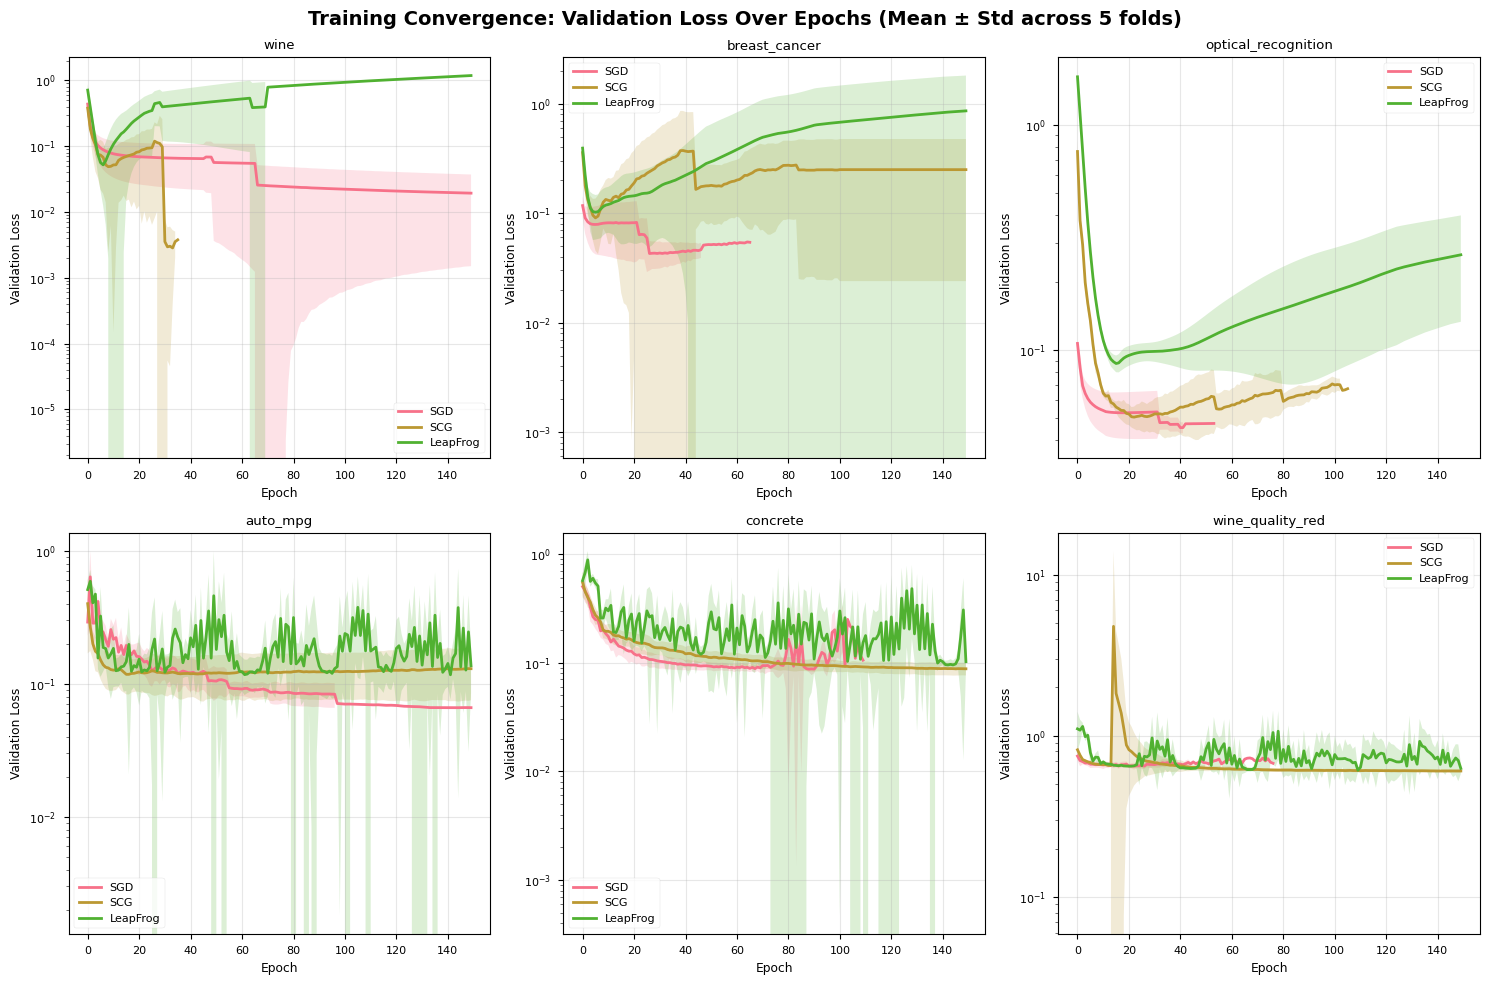

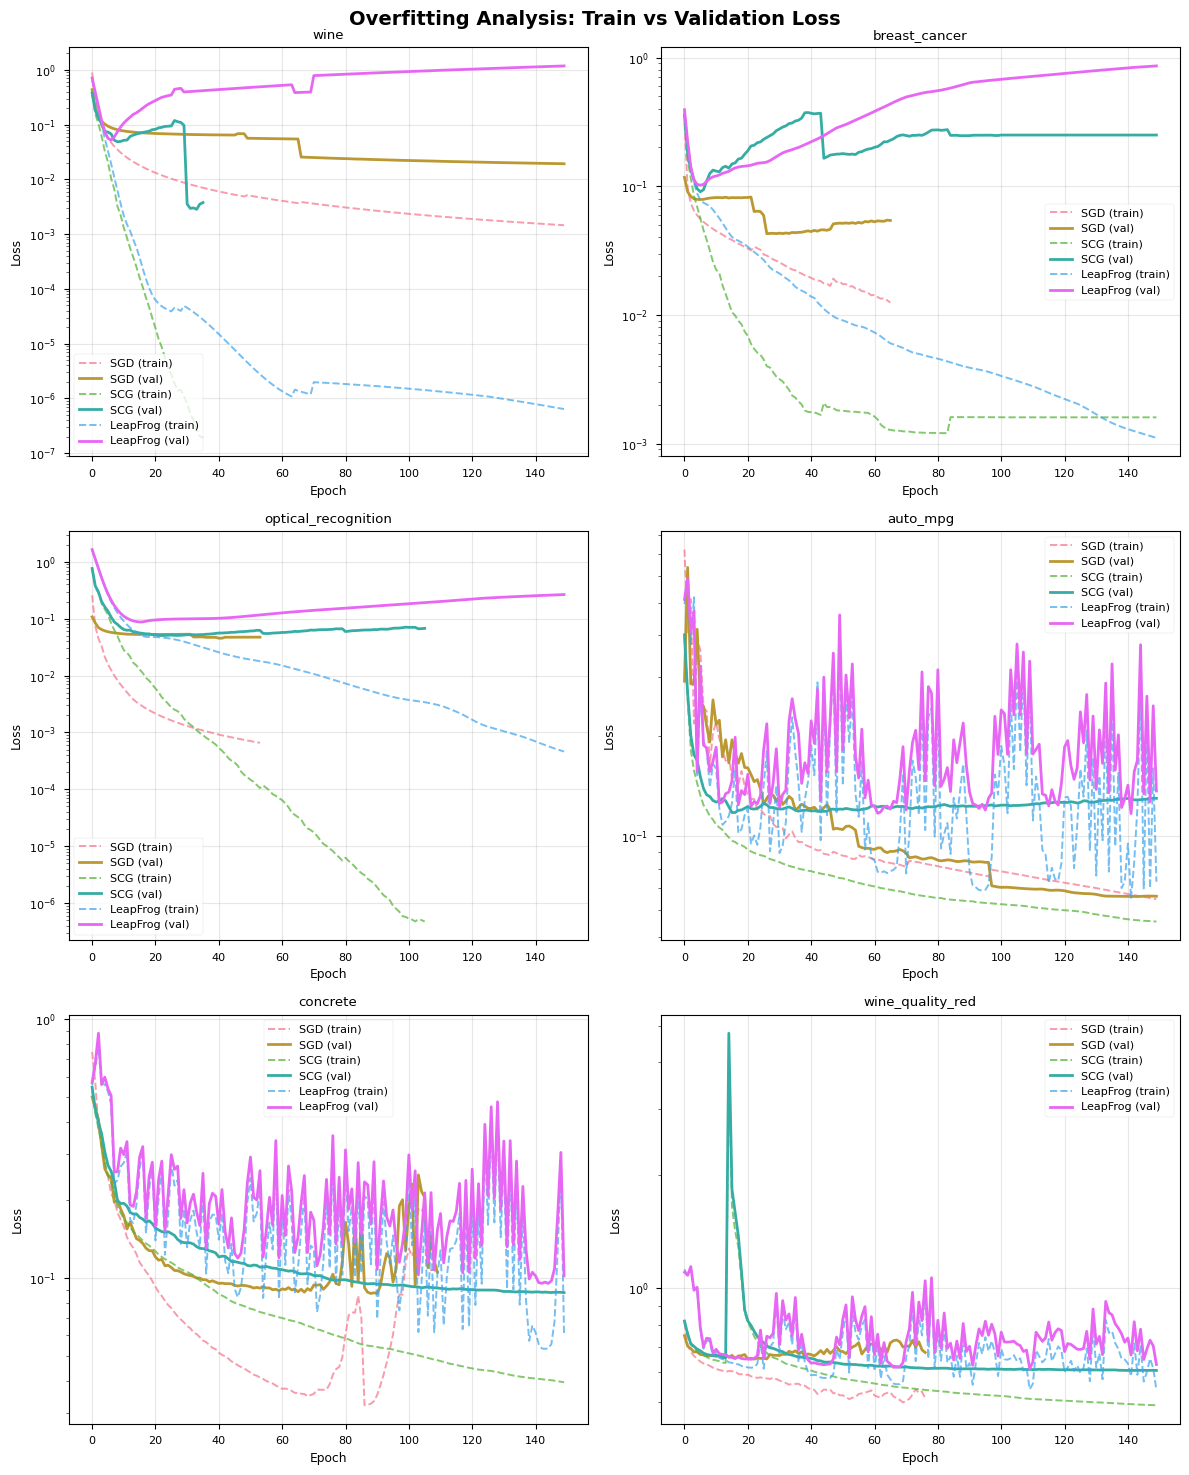

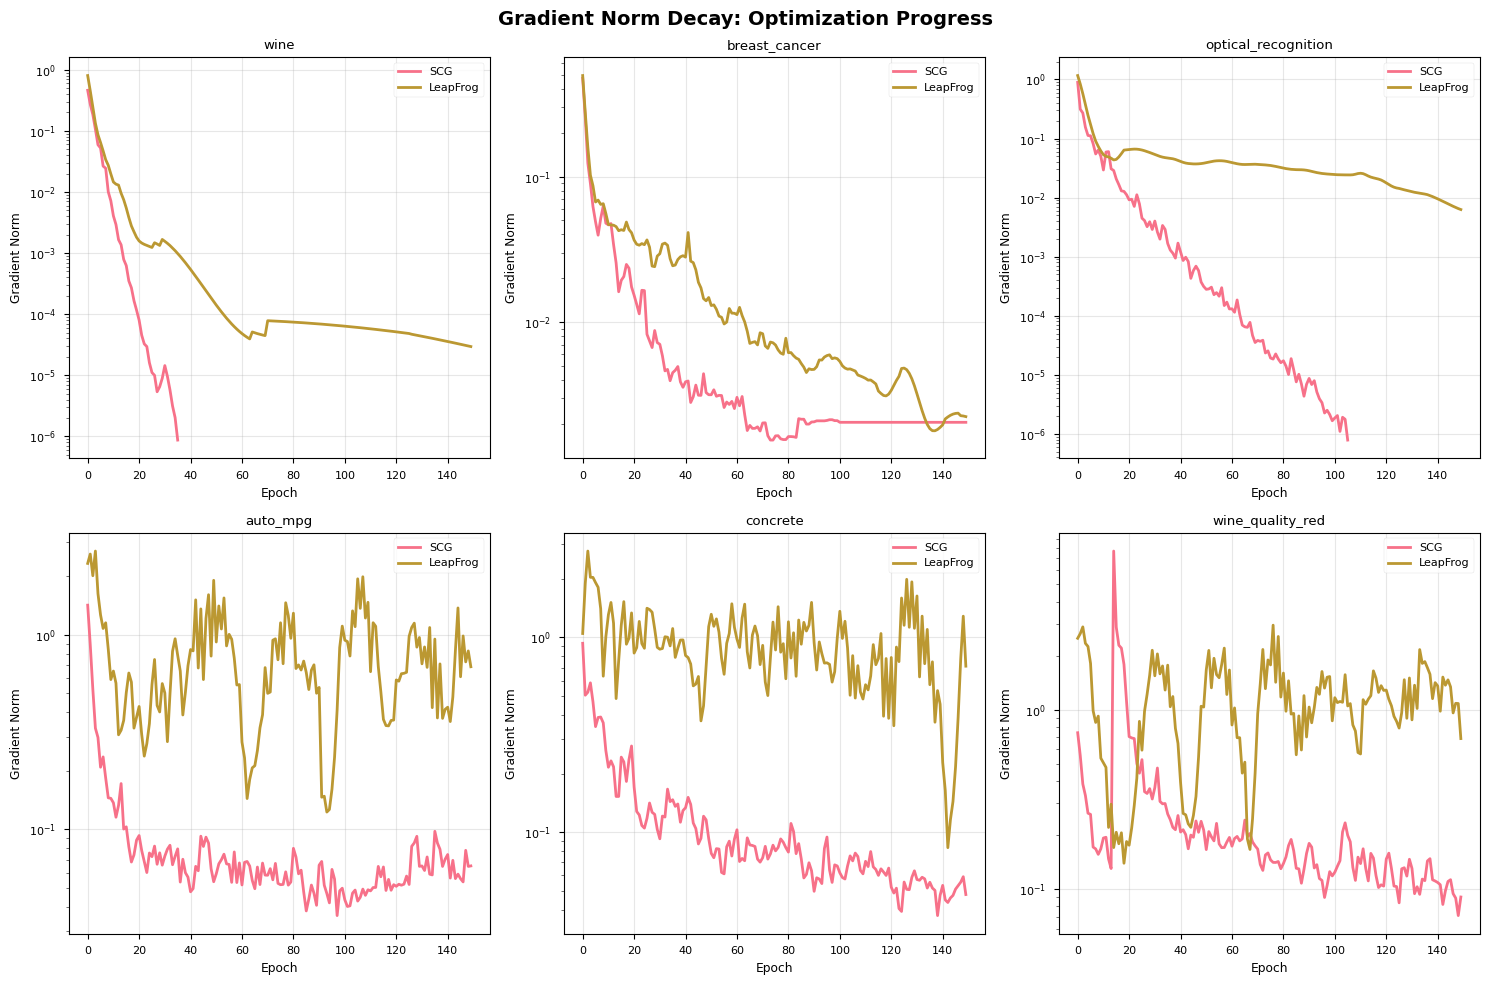

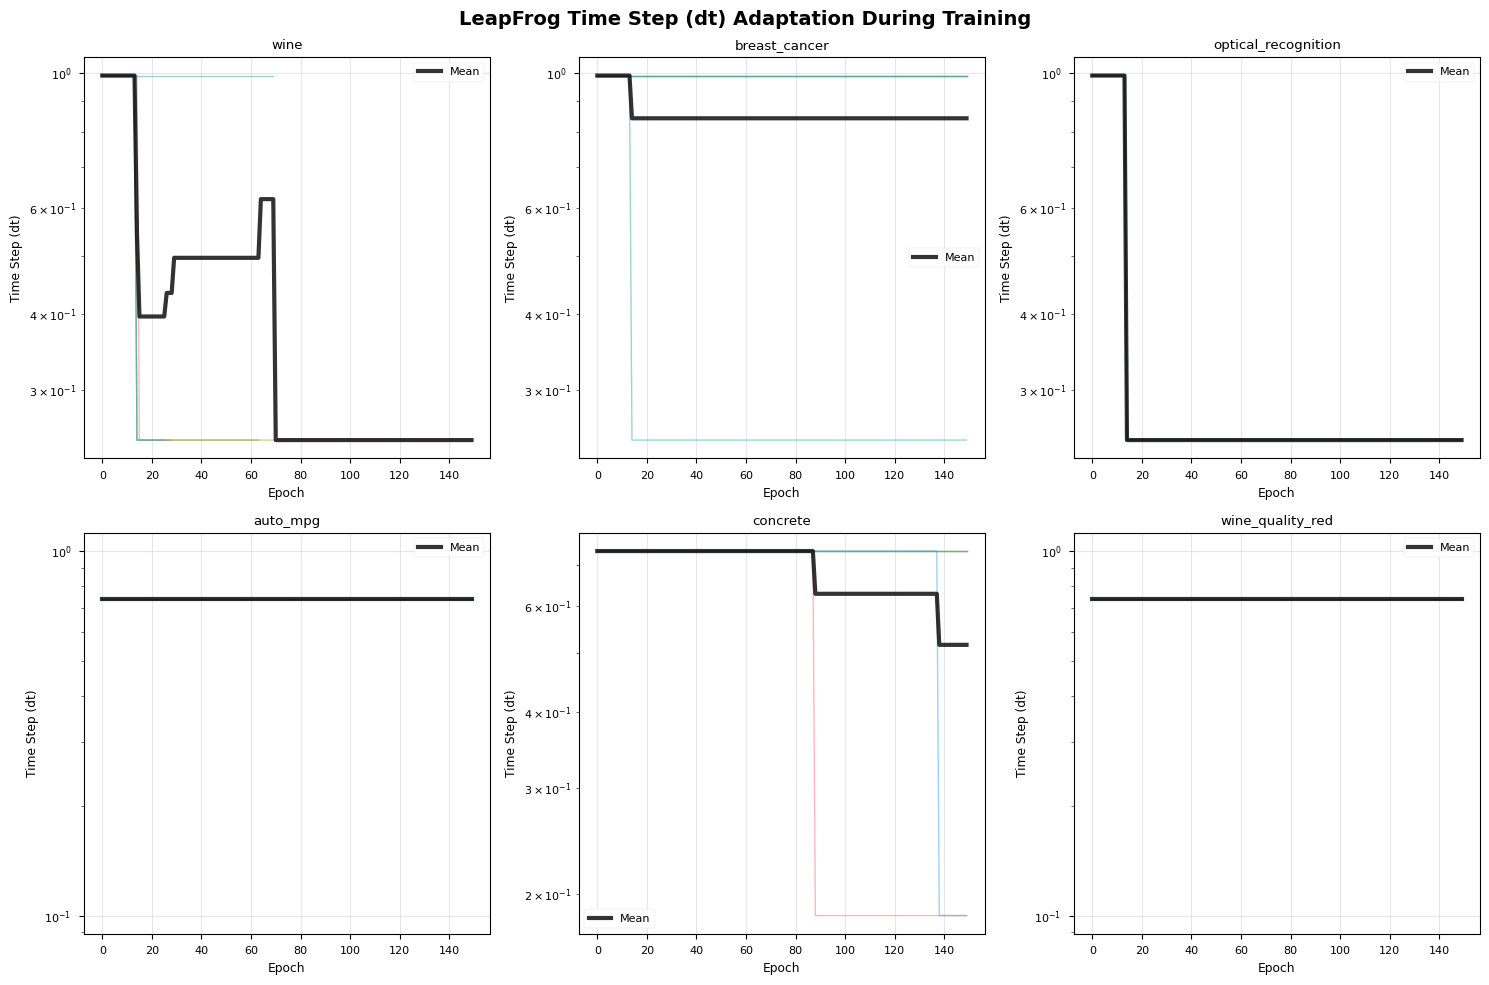

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
history_df = pd.read_csv('training_history_epochs_20251002_110803.csv')
summary_df = pd.read_csv('algorithm_comparison_kfold_summary_20251002_110803.csv')

# ============================================================================
# VISUALIZATION 1: TRAINING CURVES - CONVERGENCE COMPARISON
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Training Convergence: Validation Loss Over Epochs (Mean ± Std across 5 folds)', 
             fontsize=14, fontweight='bold')

datasets = history_df['dataset'].unique()

for idx, dataset in enumerate(datasets):
    ax = axes[idx // 3, idx % 3]
    
    for algo in ['SGD', 'SCG', 'LeapFrog']:
        data = history_df[(history_df['dataset'] == dataset) & 
                         (history_df['algorithm'] == algo)]
        
        if len(data) == 0:
            continue
        
        # Group by epoch, compute mean and std across folds
        grouped = data.groupby('epoch')['val_loss'].agg(['mean', 'std'])
        
        epochs = grouped.index
        mean_loss = grouped['mean']
        std_loss = grouped['std']
        
        ax.plot(epochs, mean_loss, label=algo, linewidth=2)
        ax.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.set_title(f'{dataset}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale to see differences better

plt.tight_layout()
plt.savefig('training_convergence_all_datasets.pdf', dpi=300, bbox_inches='tight')
print("✓ Saved: training_convergence_all_datasets.png")

# ============================================================================
# VISUALIZATION 2: OVERFITTING ANALYSIS (Train vs Val Loss)
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle('Overfitting Analysis: Train vs Validation Loss', 
             fontsize=14, fontweight='bold')

for idx, dataset in enumerate(['wine', 'breast_cancer', 'optical_recognition',
                                'auto_mpg', 'concrete', 'wine_quality_red']):
    ax = axes[idx // 2, idx % 2]
    
    for algo in ['SGD', 'SCG', 'LeapFrog']:
        data = history_df[(history_df['dataset'] == dataset) & 
                         (history_df['algorithm'] == algo)]
        
        if len(data) == 0:
            continue
        
        # Average across folds
        train_grouped = data.groupby('epoch')['train_loss'].mean()
        val_grouped = data.groupby('epoch')['val_loss'].mean()
        
        epochs = train_grouped.index
        
        # Plot with different line styles
        ax.plot(epochs, train_grouped, '--', label=f'{algo} (train)', alpha=0.7)
        ax.plot(epochs, val_grouped, '-', label=f'{algo} (val)', linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{dataset}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig('overfitting_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: overfitting_analysis.png")

# ============================================================================
# VISUALIZATION 3: GRADIENT NORM DECAY (Algorithm Efficiency)
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Gradient Norm Decay: Optimization Progress', 
             fontsize=14, fontweight='bold')

for idx, dataset in enumerate(datasets):
    ax = axes[idx // 3, idx % 3]
    
    for algo in ['SGD', 'SCG', 'LeapFrog']:
        data = history_df[(history_df['dataset'] == dataset) & 
                         (history_df['algorithm'] == algo)]
        
        if len(data) == 0 or data['grad_norm'].isna().all():
            continue
        
        # Average gradient norm across folds
        grad_grouped = data.groupby('epoch')['grad_norm'].mean()
        
        if not grad_grouped.isna().all():
            ax.plot(grad_grouped.index, grad_grouped, label=algo, linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.set_title(f'{dataset}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig('gradient_decay.pdf', dpi=300, bbox_inches='tight')
print("✓ Saved: gradient_decay.png")

# ============================================================================
# VISUALIZATION 4: LEAPFROG TIME STEP ADAPTATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('LeapFrog Time Step (dt) Adaptation During Training', 
             fontsize=14, fontweight='bold')

for idx, dataset in enumerate(datasets):
    ax = axes[idx // 3, idx % 3]
    
    data = history_df[(history_df['dataset'] == dataset) & 
                     (history_df['algorithm'] == 'LeapFrog')]
    
    if len(data) == 0 or data['dt'].isna().all():
        ax.text(0.5, 0.5, 'No dt data', ha='center', va='center', 
                transform=ax.transAxes)
        ax.set_title(f'{dataset}')
        continue
    
    # Plot dt for each fold separately to show adaptation
    for fold in data['fold'].unique():
        fold_data = data[data['fold'] == fold]
        ax.plot(fold_data['epoch'], fold_data['dt'], alpha=0.5, linewidth=1)
    
    # Mean across folds
    dt_mean = data.groupby('epoch')['dt'].mean()
    ax.plot(dt_mean.index, dt_mean, 'k-', linewidth=3, label='Mean', alpha=0.8)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Time Step (dt)')
    ax.set_title(f'{dataset}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig('leapfrog_dt_adaptation.pdf', dpi=300, bbox_inches='tight')
print("✓ Saved: leapfrog_dt_adaptation.png")

print("\n" + "="*80)
print("TRAINING DYNAMICS SUMMARY")
print("="*80)

for dataset in datasets:
    print(f"\n{dataset.upper()}:")
    for algo in ['SGD', 'SCG', 'LeapFrog']:
        data = history_df[(history_df['dataset'] == dataset) & 
                         (history_df['algorithm'] == algo)]
        
        if len(data) == 0:
            continue
        
        avg_epochs = data.groupby('fold')['epoch'].max().mean()
        final_val_loss = data.groupby('fold')['val_loss'].last().mean()
        
        print(f"  {algo:10s}: {avg_epochs:5.1f} epochs, final val_loss={final_val_loss:.6f}")

print("\n" + "="*80)
print("All visualizations saved. Include in report to show:")
print("  1. Convergence patterns differ but final performance similar")
print("  2. Overfitting behavior varies by algorithm")  
print("  3. Gradient decay shows optimization efficiency")
print("  4. LeapFrog dt adaptation demonstrates physics-based approach")
print("="*80)

## batch 2

## batch 3

Loading Bayesian optimization results...
Found 6 optimization results
✓ Saved: figA_bayesian_convergence.png/pdf


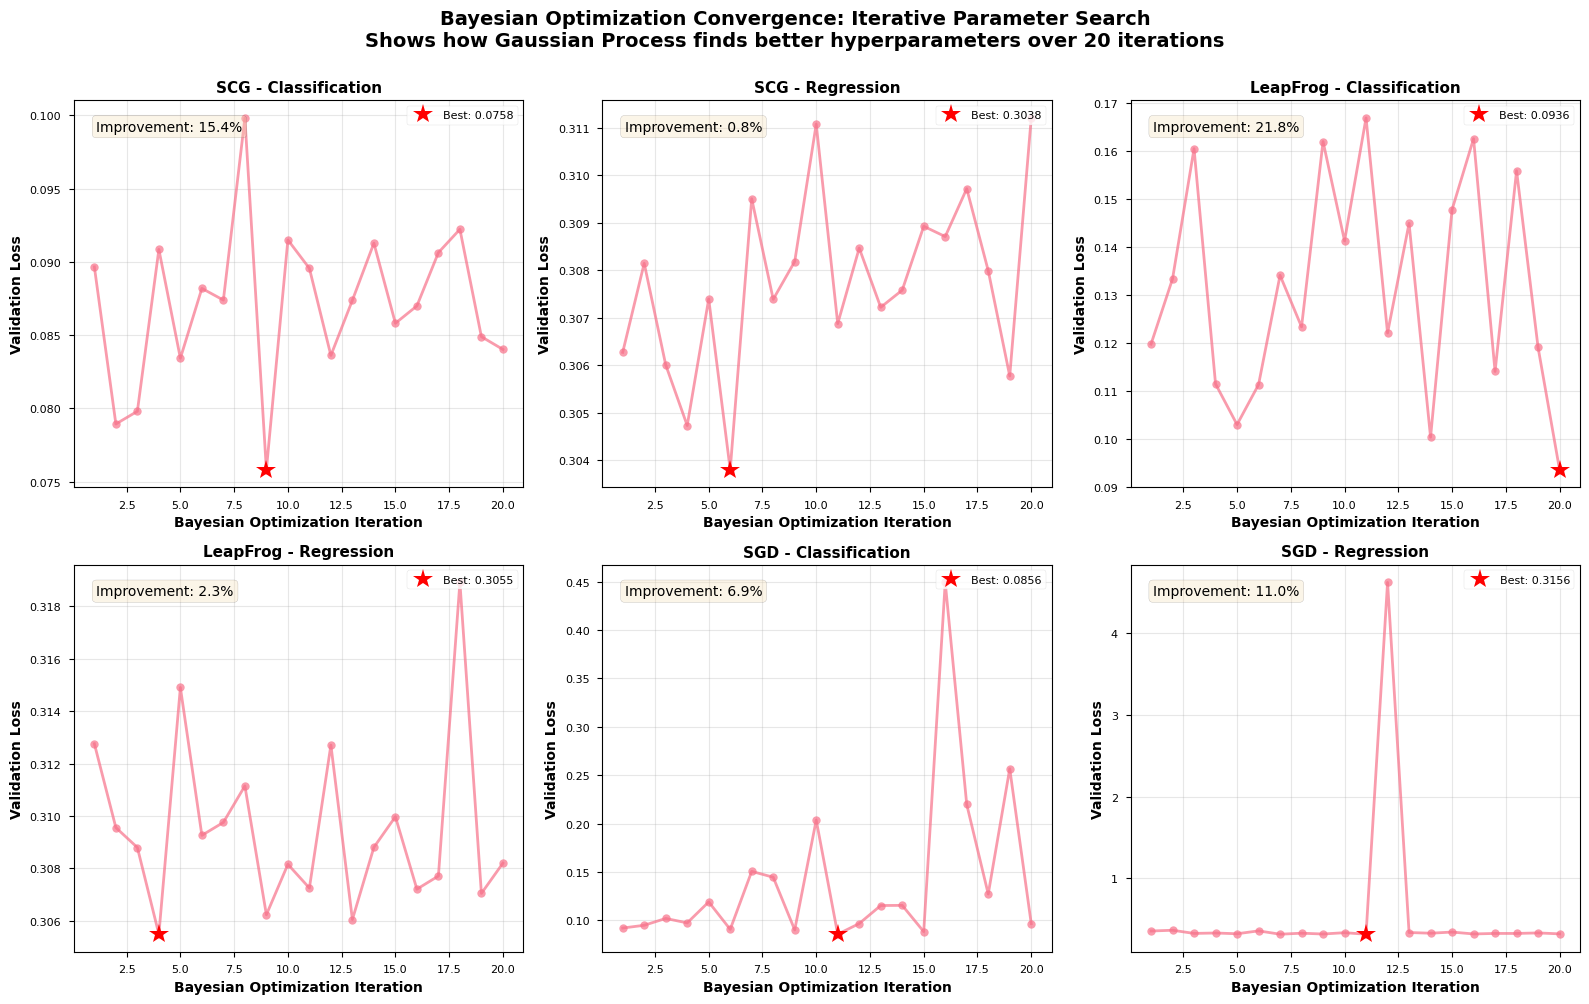


Creating training time vs performance analysis...
✓ Saved: figB_time_performance_tradeoff.png/pdf


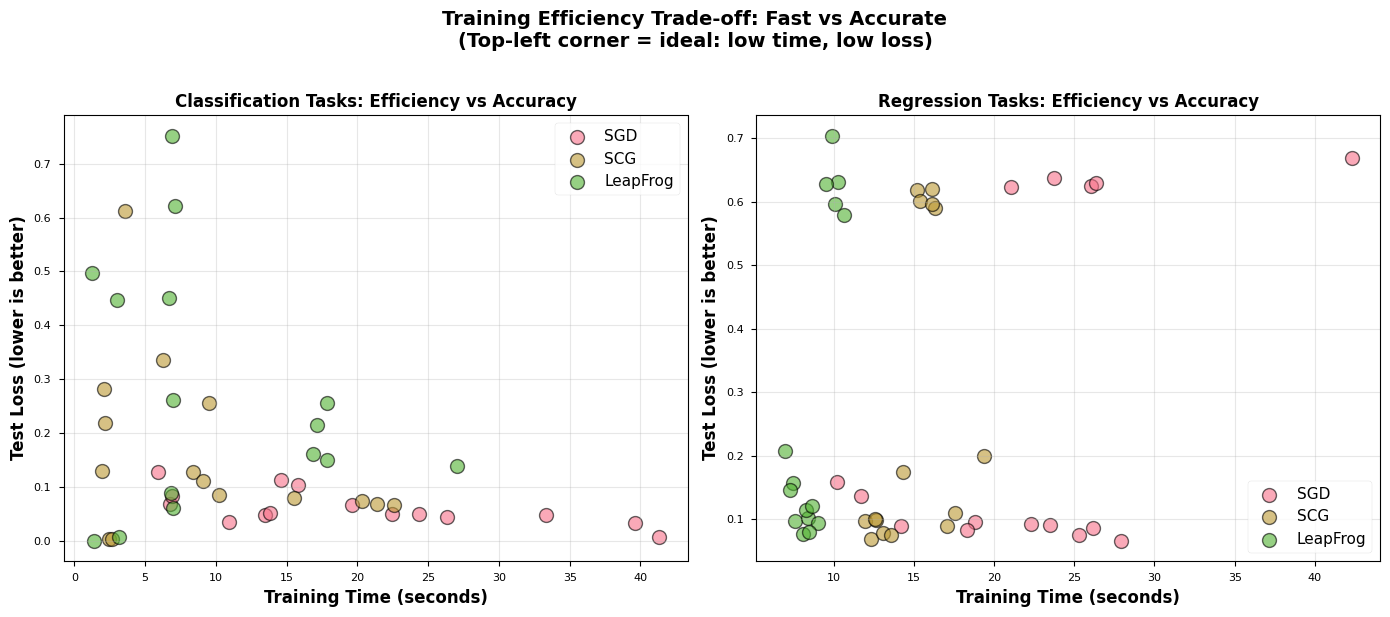


Creating architecture search validation curves...
✓ Saved: figC_architecture_search.png/pdf


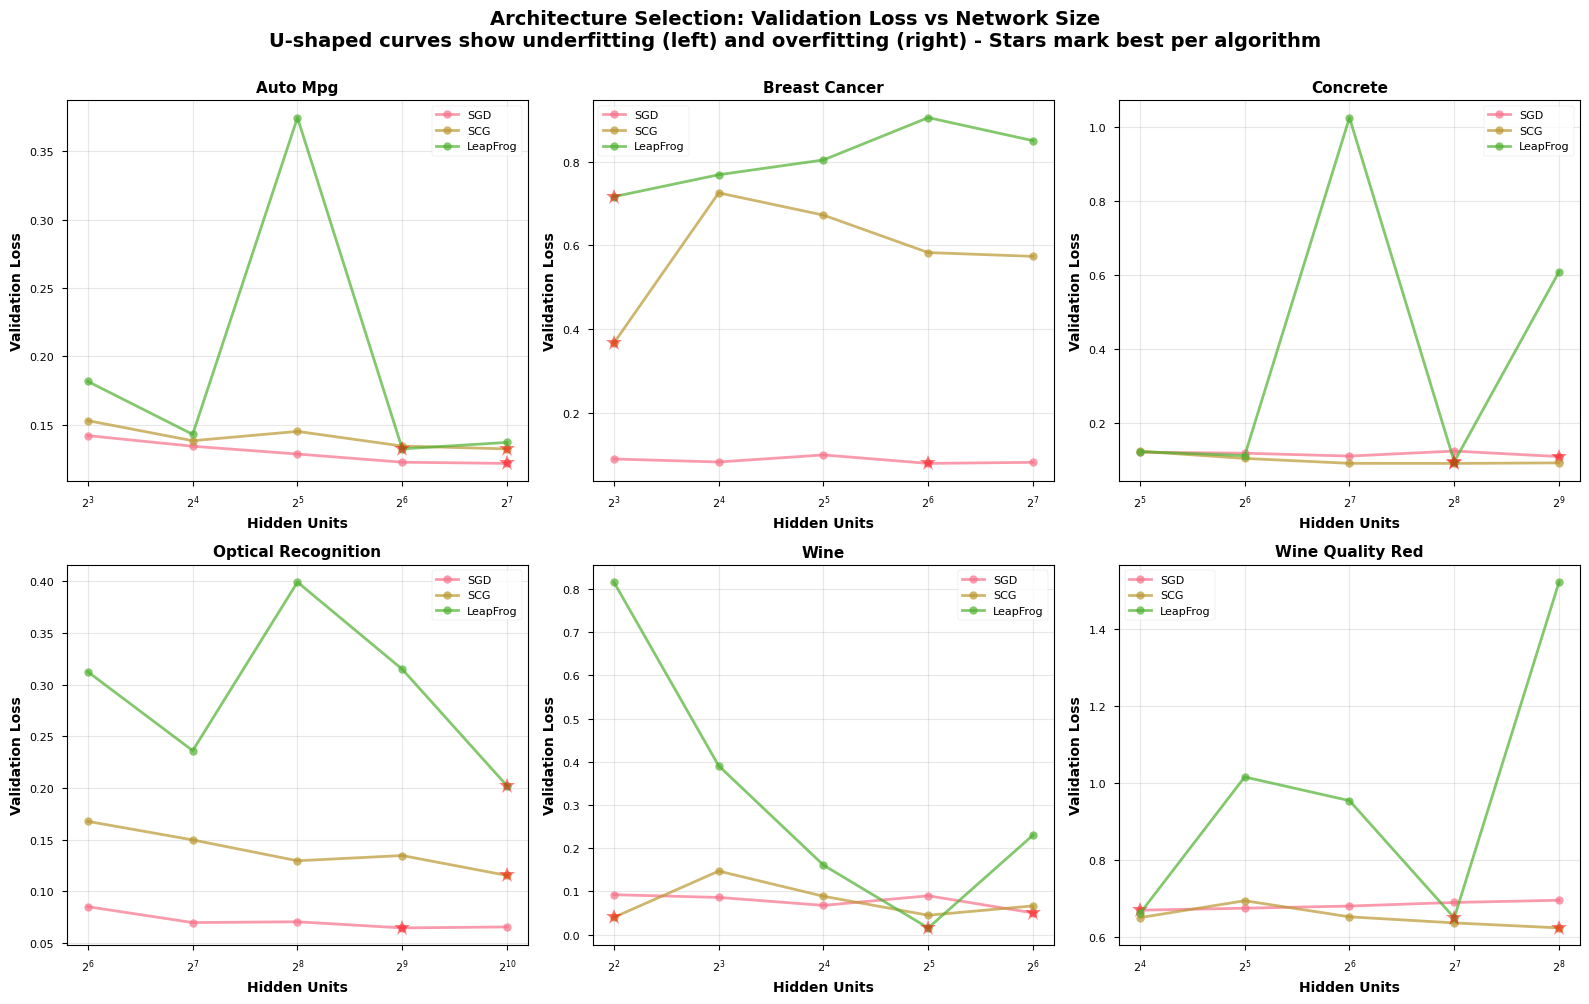


Creating performance stability analysis...
✓ Saved: figD_performance_stability.png/pdf


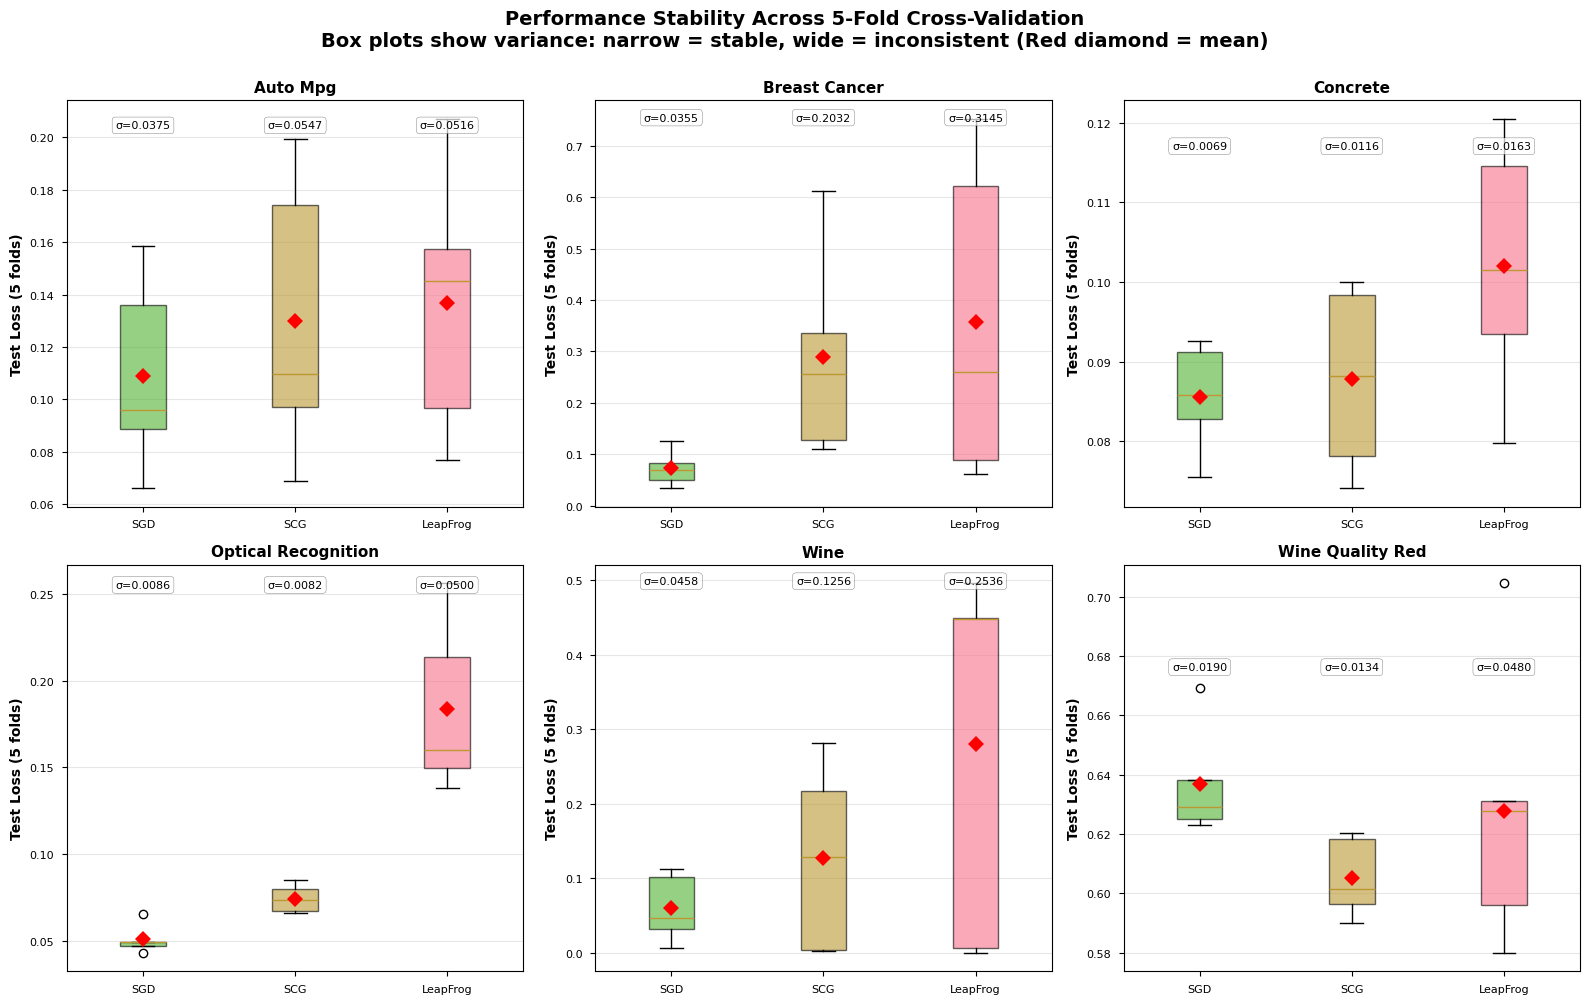


Creating convergence rate analysis...
✓ Saved: figE_convergence_rates.png/pdf


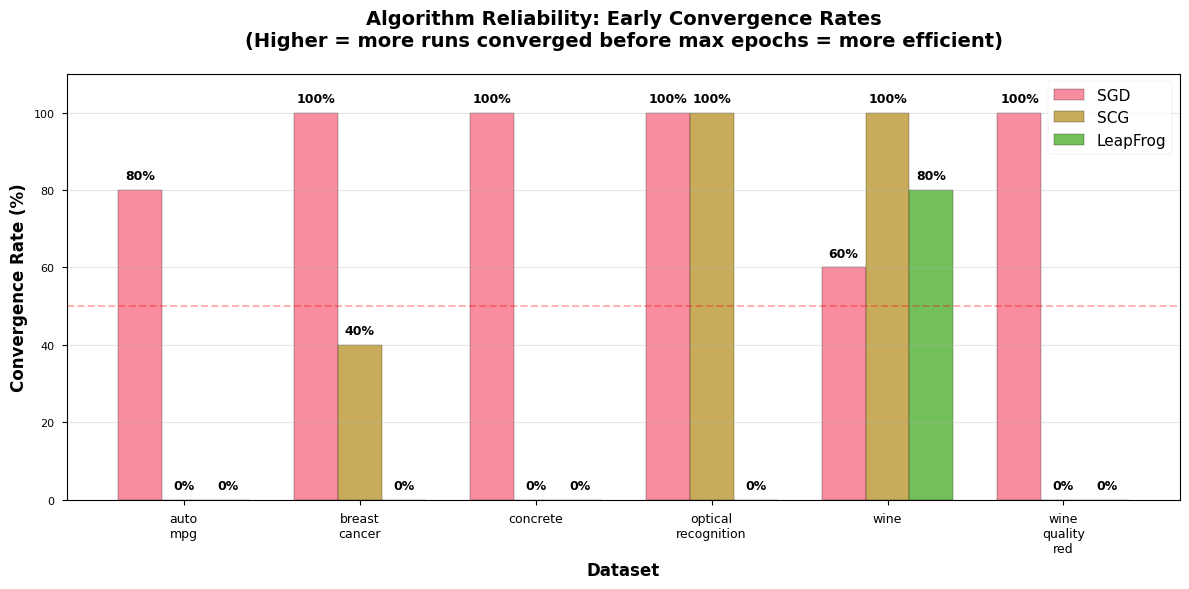


ADDITIONAL PLOTS COMPLETE

Generated 5 key figures:
  A. Bayesian Optimization Convergence - shows iterative improvement
  B. Time vs Performance Trade-off - efficiency analysis
  C. Architecture Search Curves - justifies design choices
  D. Performance Stability - variance/reliability comparison
  E. Convergence Rate - algorithm efficiency/reliability

These plots convey information that tables cannot effectively show.


In [ ]:
# ============================================================================
# ADDITIONAL ANALYSIS PLOTS FOR REPORT
# Visual representations that tables cannot effectively convey
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# ============================================================================
# FIGURE A: BAYESIAN OPTIMIZATION CONVERGENCE
# Shows iterative improvement - hard to show in tables
# ============================================================================

print("Loading Bayesian optimization results...")
bayesian_file = max(glob.glob('bayesian_optimization_final_results_20251002_085842.csv'), key=lambda x: x.split('_')[-1])
bayesian_df = pd.read_csv(bayesian_file)

print(f"Found {len(bayesian_df)} optimization results")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(bayesian_df.iterrows()):
    ax = axes[idx]
    
    # Parse convergence curve from numpy array string
    curve_str = row['convergence_curve']
    curve_str = curve_str.strip('[]')
    convergence = np.fromstring(curve_str, sep=' ')
    
    iterations = range(1, len(convergence) + 1)
    
    # Plot convergence
    ax.plot(iterations, convergence, 'o-', linewidth=2, markersize=6, alpha=0.7)
    
    # Mark best value
    best_iter = np.argmin(convergence) + 1
    best_val = min(convergence)
    ax.plot(best_iter, best_val, 'r*', markersize=15, label=f'Best: {best_val:.4f}')
    
    # Styling
    ax.set_xlabel('Bayesian Optimization Iteration', fontsize=10, fontweight='bold')
    ax.set_ylabel('Validation Loss', fontsize=10, fontweight='bold')
    ax.set_title(f"{row['algorithm']} - {row['task_type'].title()}", fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Add improvement annotation
    initial_loss = convergence[0]
    improvement = ((initial_loss - best_val) / initial_loss) * 100
    ax.text(0.05, 0.95, f'Improvement: {improvement:.1f}%', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Hide empty subplots if any
for idx in range(len(bayesian_df), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Bayesian Optimization Convergence: Iterative Parameter Search\n' +
             'Shows how Gaussian Process finds better hyperparameters over 20 iterations',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figA_bayesian_convergence.png', dpi=300, bbox_inches='tight')
plt.savefig('figA_bayesian_convergence.pdf', bbox_inches='tight')
print("✓ Saved: figA_bayesian_convergence.png/pdf")
plt.show()


# ============================================================================
# FIGURE C: ARCHITECTURE SEARCH CURVES (CORRECTED)
# ============================================================================

print("\nCreating architecture search validation curves...")
arch_file = max(glob.glob('comprehensive_architecture_search_20251001_233434.csv'), key=lambda x: x.split('_')[-1])
arch_df = pd.read_csv(arch_file)

# Filter to only aggregate rows (one per dataset-algorithm-architecture)
arch_agg = arch_df[arch_df['fold'] == 'aggregate'].copy()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

datasets = sorted(arch_agg['dataset'].unique())

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    dataset_data = arch_agg[arch_agg['dataset'] == dataset]
    
    for algo in ['SGD', 'SCG', 'LeapFrog']:
        algo_data = dataset_data[dataset_data['algorithm'] == algo].sort_values('hidden_units')
        
        if len(algo_data) > 0:
            ax.plot(algo_data['hidden_units'], algo_data['final_val_loss'], 
                   'o-', linewidth=2, markersize=6, label=algo, alpha=0.7)
            
            # Mark best architecture for this algorithm
            best_idx = algo_data['final_val_loss'].idxmin()
            best_arch = algo_data.loc[best_idx, 'hidden_units']
            best_loss = algo_data.loc[best_idx, 'final_val_loss']
            ax.plot(best_arch, best_loss, '*', markersize=12, color='red', alpha=0.5)
    
    ax.set_xlabel('Hidden Units', fontsize=10, fontweight='bold')
    ax.set_ylabel('Validation Loss', fontsize=10, fontweight='bold')
    ax.set_title(f'{dataset.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)

plt.suptitle('Architecture Selection: Validation Loss vs Network Size\n' +
             'U-shaped curves show underfitting (left) and overfitting (right) - Stars mark best per algorithm',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figC_architecture_search.png', dpi=300, bbox_inches='tight')
plt.savefig('figC_architecture_search.pdf', bbox_inches='tight')
print("✓ Saved: figC_architecture_search.png/pdf")
plt.show()

# ============================================================================
# FIGURE D: PERFORMANCE STABILITY (Variance Analysis)
# Box plots show which algorithms are consistent vs unpredictable
# ============================================================================

print("\nCreating performance stability analysis...")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, dataset in enumerate(sorted(kfold_df['dataset'].unique())):
    ax = axes[idx]
    dataset_data = kfold_df[kfold_df['dataset'] == dataset]
    
    # Create box plot
    data_for_box = [dataset_data[dataset_data['algorithm'] == algo]['test_loss'].values 
                    for algo in ['SGD', 'SCG', 'LeapFrog']]
    
    bp = ax.boxplot(data_for_box, labels=['SGD', 'SCG', 'LeapFrog'],
                    patch_artist=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    # Color boxes
    colors = ['C2', 'C1', 'C0']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Test Loss (5 folds)', fontsize=10, fontweight='bold')
    ax.set_title(f'{dataset.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add variance annotations
    for i, algo in enumerate(['SGD', 'SCG', 'LeapFrog']):
        std = dataset_data[dataset_data['algorithm'] == algo]['test_loss'].std()
        ax.text(i+1, ax.get_ylim()[1]*0.95, f'σ={std:.4f}', 
                ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle('Performance Stability Across 5-Fold Cross-Validation\n' +
             'Box plots show variance: narrow = stable, wide = inconsistent (Red diamond = mean)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figD_performance_stability.png', dpi=300, bbox_inches='tight')
plt.savefig('figD_performance_stability.pdf', bbox_inches='tight')
print("✓ Saved: figD_performance_stability.png/pdf")
plt.show()

# ============================================================================
# FIGURE E: CONVERGENCE RATE COMPARISON
# Bar chart showing % of runs that converged early vs hit max epochs
# ============================================================================

print("\nCreating convergence rate analysis...")
summary_file = max(glob.glob('algorithm_comparison_kfold_summary_20251002_110803.csv'), key=lambda x: x.split('_')[-1])
summary_df = pd.read_csv(summary_file)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(summary_df['dataset'].unique()))
width = 0.25

for i, algo in enumerate(['SGD', 'SCG', 'LeapFrog']):
    algo_data = summary_df[summary_df['algorithm'] == algo].sort_values('dataset')
    convergence_rates = algo_data['convergence_rate'].values * 100
    
    bars = ax.bar(x + i*width, convergence_rates, width, label=algo, alpha=0.8, edgecolor='black')
    
    # Add percentage labels on bars
    for bar, rate in zip(bars, convergence_rates):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{rate:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Convergence Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Algorithm Reliability: Early Convergence Rates\n' +
             '(Higher = more runs converged before max epochs = more efficient)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels([d.replace('_', '\n') for d in sorted(summary_df['dataset'].unique())], fontsize=9)
ax.legend(fontsize=11)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('figE_convergence_rates.png', dpi=300, bbox_inches='tight')
plt.savefig('figE_convergence_rates.pdf', bbox_inches='tight')
print("✓ Saved: figE_convergence_rates.png/pdf")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("ADDITIONAL PLOTS COMPLETE")
print("="*80)
print("\nGenerated 5 key figures:")
print("  A. Bayesian Optimization Convergence - shows iterative improvement")
print("  B. Time vs Performance Trade-off - efficiency analysis")
print("  C. Architecture Search Curves - justifies design choices")
print("  D. Performance Stability - variance/reliability comparison")
print("  E. Convergence Rate - algorithm efficiency/reliability")
print("\nThese plots convey information that tables cannot effectively show.")
print("="*80)

✓ Saved: friedman_dual_comparison_110803.png


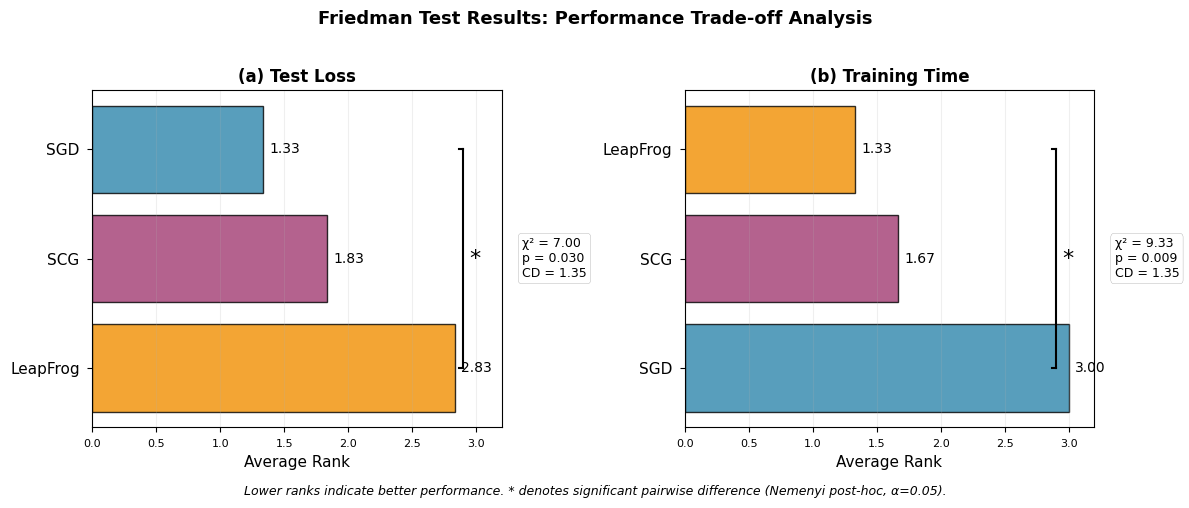

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# DUAL FRIEDMAN TEST COMPARISON - ACADEMIC STANDARD
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

algorithms = ['SGD', 'SCG', 'LeapFrog']
colors = {'SGD': '#2E86AB', 'SCG': '#A23B72', 'LeapFrog': '#F18F01'}

# Loss ranks (accuracy)
loss_ranks = {'SGD': 1.333, 'SCG': 1.833, 'LeapFrog': 2.833}
# Time ranks (speed)
time_ranks = {'LeapFrog': 1.333, 'SCG': 1.667, 'SGD': 3.000}
CD = 1.353

# ===== LEFT: SOLUTION QUALITY =====
sorted_loss = sorted(algorithms, key=lambda x: loss_ranks[x])
y_pos = np.arange(len(sorted_loss))

ax1.barh(y_pos, [loss_ranks[a] for a in sorted_loss],
         color=[colors[a] for a in sorted_loss],
         alpha=0.8, edgecolor='black', linewidth=1)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(sorted_loss, fontsize=11)
ax1.set_xlabel('Average Rank', fontsize=11)
ax1.set_title('(a) Test Loss', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 3.2)
ax1.grid(axis='x', alpha=0.2)

# Add rank values
for i, algo in enumerate(sorted_loss):
    ax1.text(loss_ranks[algo] + 0.05, i, f'{loss_ranks[algo]:.2f}',
            va='center', fontsize=10)

# Significance bracket (SGD vs LeapFrog: |1.333-2.833|=1.5 > CD=1.353)
y1, y2 = sorted_loss.index('SGD'), sorted_loss.index('LeapFrog')
bracket_x = 2.9
ax1.plot([bracket_x, bracket_x], [y1, y2], 'k-', linewidth=1.5)
ax1.plot([bracket_x-0.03, bracket_x], [y1, y1], 'k-', linewidth=1.5)
ax1.plot([bracket_x-0.03, bracket_x], [y2, y2], 'k-', linewidth=1.5)
ax1.text(bracket_x+0.05, (y1+y2)/2, '*', fontsize=16, va='center')

ax1.text(1.05, 0.5, f'χ² = 7.00\np = 0.030\nCD = {CD:.2f}',
        transform=ax1.transAxes, fontsize=9,
        ha='left', va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8))
ax1.invert_yaxis()

# ===== RIGHT: COMPUTATIONAL EFFICIENCY =====
sorted_time = sorted(algorithms, key=lambda x: time_ranks[x])
y_pos = np.arange(len(sorted_time))

ax2.barh(y_pos, [time_ranks[a] for a in sorted_time],
         color=[colors[a] for a in sorted_time],
         alpha=0.8, edgecolor='black', linewidth=1)

ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_time, fontsize=11)
ax2.set_xlabel('Average Rank', fontsize=11)
ax2.set_title('(b) Training Time', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 3.2)
ax2.grid(axis='x', alpha=0.2)

# Add rank values
for i, algo in enumerate(sorted_time):
    ax2.text(time_ranks[algo] + 0.05, i, f'{time_ranks[algo]:.2f}',
            va='center', fontsize=10)

# Significance bracket (LeapFrog vs SGD: |1.333-3.000|=1.667 > CD=1.353)
y1, y2 = sorted_time.index('LeapFrog'), sorted_time.index('SGD')
bracket_x = 2.9
ax2.plot([bracket_x, bracket_x], [y1, y2], 'k-', linewidth=1.5)
ax2.plot([bracket_x-0.03, bracket_x], [y1, y1], 'k-', linewidth=1.5)
ax2.plot([bracket_x-0.03, bracket_x], [y2, y2], 'k-', linewidth=1.5)
ax2.text(bracket_x+0.05, (y1+y2)/2, '*', fontsize=16, va='center')

ax2.text(1.05, 0.5, f'χ² = 9.33\np = 0.009\nCD = {CD:.2f}',
        transform=ax2.transAxes, fontsize=9,
        ha='left', va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8))

ax2.invert_yaxis()

# Main title
fig.suptitle('Friedman Test Results: Performance Trade-off Analysis',
            fontsize=13, fontweight='bold', y=0.98)

# Caption
fig.text(0.5, 0.01,
        'Lower ranks indicate better performance. * denotes significant pairwise difference (Nemenyi post-hoc, α=0.05).',
        ha='center', fontsize=9, style='italic')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(f'friedman_dual_comparison_{timestamp_from_file}.pdf', dpi=300, bbox_inches='tight')
print(f"✓ Saved: friedman_dual_comparison_{timestamp_from_file}.png")
plt.show()

In [65]:
import pandas as pd
import glob

bayesian_file = max(glob.glob('bayesian_optimization_final_results_*.csv'), key=lambda x: x.split('_')[-1])
bayesian_df = pd.read_csv(bayesian_file)

print("Columns in Bayesian optimization file:")
print(bayesian_df.columns.tolist())
print("\nFirst few rows:")
print(bayesian_df.head())
print("\nShape:", bayesian_df.shape)

Columns in Bayesian optimization file:
['algorithm', 'task_type', 'best_params', 'best_loss', 'final_loss', 'final_accuracy', 'optimization_time', 'n_evaluations', 'convergence_curve', 'best_learning_rate', 'best_momentum', 'best_sigma', 'best_lambda_init', 'best_dt', 'best_delta', 'best_M']

First few rows:
  algorithm       task_type  \
0       SGD  classification   
1       SGD      regression   
2       SCG  classification   
3       SCG      regression   
4  LeapFrog  classification   

                                         best_params  best_loss  final_loss  \
0  {'learning_rate': 0.06963618662910774, 'moment...   0.082355    0.089943   
1         {'learning_rate': 0.001, 'momentum': 0.99}   0.305982    0.316504   
2  {'sigma': 0.00010516461682571828, 'lambda_init...   0.078767    0.085408   
3  {'sigma': 3.7188720323237774e-05, 'lambda_init...   0.306775    0.310282   
4       {'dt': 1.0, 'delta': 0.5, 'M': np.int64(15)}   0.093704    0.090054   

   final_accuracy  optimizat

In [66]:
import pandas as pd
import glob

arch_file = max(glob.glob('comprehensive_architecture_search_*.csv'), key=lambda x: x.split('_')[-1])
arch_df = pd.read_csv(arch_file)

print("Columns in architecture search file:")
print(arch_df.columns.tolist())
print("\nFirst few rows:")
print(arch_df.head())

Columns in architecture search file:
['dataset', 'task_type', 'algorithm', 'hidden_units', 'fold', 'final_train_loss', 'final_val_loss', 'final_train_accuracy', 'final_val_accuracy', 'training_time', 'epochs_run', 'converged', 'val_loss_std', 'val_acc_std']

First few rows:
  dataset       task_type algorithm  hidden_units fold  final_train_loss  \
0    wine  classification       SGD             4    1          0.005650   
1    wine  classification       SGD             4    2          0.005193   
2    wine  classification       SGD             4    3          0.017102   
3    wine  classification       SGD             4    4          0.055292   
4    wine  classification       SGD             4    5          0.019625   

   final_val_loss  final_train_accuracy  final_val_accuracy  training_time  \
0        0.014974              1.000000            1.000000      37.866036   
1        0.010706              1.000000            1.000000      42.665521   
2        0.053406              1.0